In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install koreanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 54.4 MB/s eta 0:00:00


In [2]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 13.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import koreanize_matplotlib
import warnings
import copy
from hyperopt import fmin, tpe, hp, Trials, space_eval
from xgboost import XGBClassifier
from imblearn.over_sampling import BorderlineSMOTE, RandomOverSampler, ADASYN, SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
%matplotlib inline

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/데이터스쿨/평일3조/data/BankChurners.csv')

# drop 컬럼
df.drop(['CLIENTNUM','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis=1, inplace=True)

# 컬럼명 변경
df.columns = ['Exited', 'Age', 'Gender', 'Dependents', 'Education', 'Marital', 'Income', 'Card_Type',
              'Tenure', 'Product_Cnt', 'Inactive_Months', 'Contacts_Cnt', 'Credit_Limit','Revolv_Bal', 'Avg_OTB', 'Amt_Chng_Q4_Q1',
              'Trans_Amt', 'Trans_Cnt', 'Cnt_Chng_Q4_Q1', 'Avg_Util_Ratio']

# 컬럼 순서 변경
df = df[['Exited', 'Age', 'Gender', 'Dependents', 'Education', 'Marital', 'Income', 'Card_Type',
         'Tenure', 'Product_Cnt', 'Inactive_Months', 'Contacts_Cnt', 'Credit_Limit','Revolv_Bal', 'Avg_OTB',
         'Avg_Util_Ratio', 'Trans_Amt', 'Trans_Cnt', 'Amt_Chng_Q4_Q1', 'Cnt_Chng_Q4_Q1']]

df.head()

,Exited,Age,Gender,Dependents,Education,Marital,Income,Card_Type,Tenure,Product_Cnt,Inactive_Months,Contacts_Cnt,Credit_Limit,Revolv_Bal,Avg_OTB,Avg_Util_Ratio,Trans_Amt,Trans_Cnt,Amt_Chng_Q4_Q1,Cnt_Chng_Q4_Q1
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,0.061,1144,42,1.335,1.625
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,0.105,1291,33,1.541,3.714
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,0.000,1887,20,2.594,2.333
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,0.760,1171,20,1.405,2.333
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,0.000,816,28,2.175,2.500


In [ ]:
df.describe()

,Age,Dependents,Tenure,Product_Cnt,Inactive_Months,Contacts_Cnt,Credit_Limit,Revolv_Bal,Avg_OTB,Avg_Util_Ratio,Trans_Amt,Trans_Cnt,Amt_Chng_Q4_Q1,Cnt_Chng_Q4_Q1
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.274894,4404.086304,64.858695,0.759941,0.712222
std,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.275691,3397.129254,23.472570,0.219207,0.238086
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.023000,2155.500000,45.000000,0.631000,0.582000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.176000,3899.000000,67.000000,0.736000,0.702000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.503000,4741.000000,81.000000,0.859000,0.818000
max,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,0.999000,18484.000000,139.000000,3.397000,3.714000


In [ ]:
# 결측치 확인
df.isnull().sum()

Exited             0
Age                0
Gender             0
Dependents         0
Education          0
Marital            0
Income             0
Card_Type          0
Tenure             0
Product_Cnt        0
Inactive_Months    0
Contacts_Cnt       0
Credit_Limit       0
Revolv_Bal         0
Avg_OTB            0
Avg_Util_Ratio     0
Trans_Amt          0
Trans_Cnt          0
Amt_Chng_Q4_Q1     0
Cnt_Chng_Q4_Q1     0
dtype: int64

## 1. EDA
- df_eda1: 한정연
- df_eda2: 김승민
- df_eda3: 한상현
- df_eda4: 박영주, 전체 컬럼 boxplot
- deep copy 해주세요!

Age
- 40 ~ 50대가 주요 고객
- 나이가 이탈에 영향을 주지 않는다.

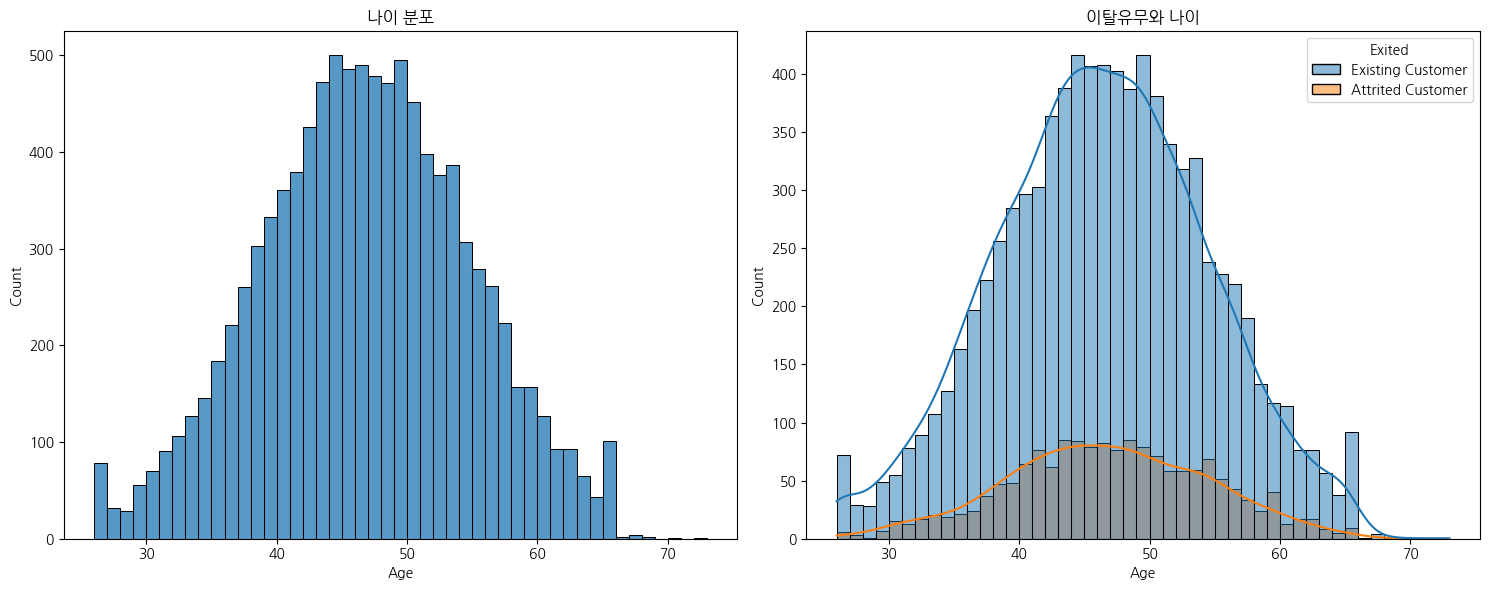

In [ ]:
# df copy
df1 = copy.deepcopy(df)

# 나이 분포
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.title('나이 분포')
sns.histplot(x='Age', data=df1)

# 이탈 & 나이
plt.subplot(1, 2, 2)
sns.histplot(x='Age', data=df1, hue='Exited', kde=True)
plt.title('이탈유무와 나이')
plt.tight_layout()
plt.show()

Gender
- 남성보다 여성의 비율이 높다.
- 성별이 이탈에 영향을 주지는 않는다.

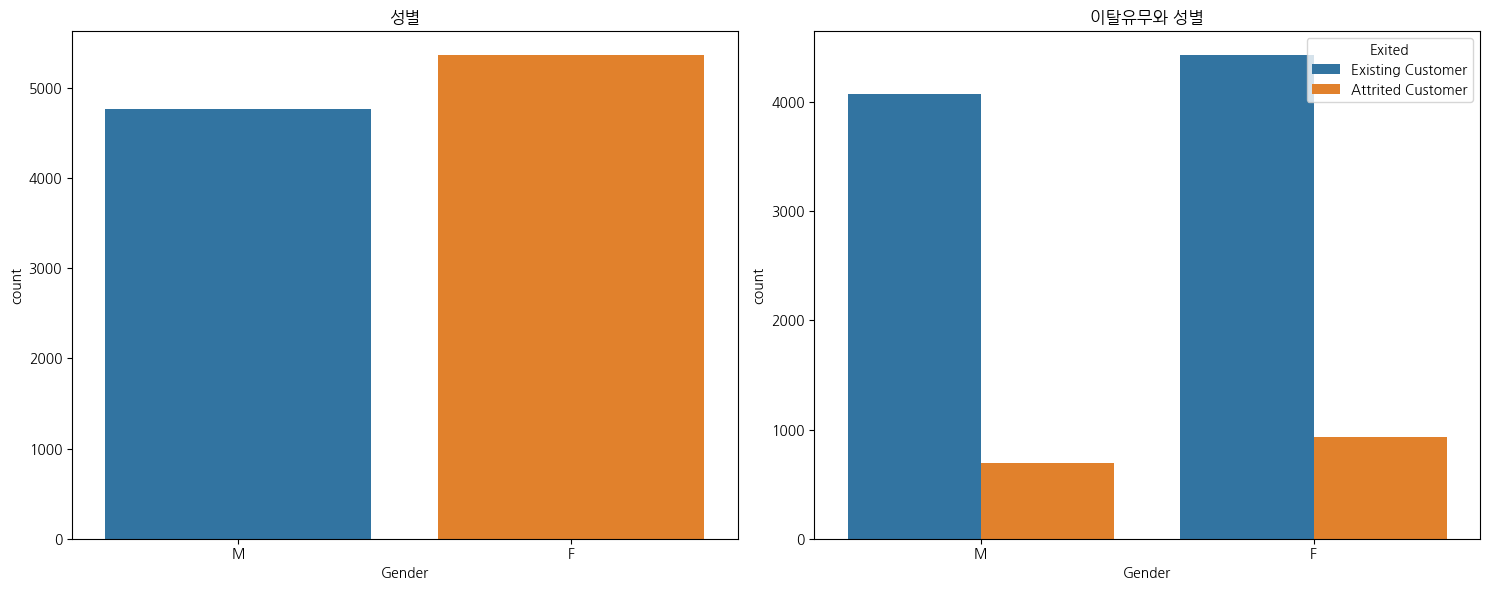

In [ ]:
# gender
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.title('성별')
sns.countplot(x='Gender', data=df1)

# Gender & 이탈
plt.subplot(1, 2, 2)
sns.countplot(x='Gender', data=df1, hue='Exited')
plt.title('이탈유무와 성별')
plt.tight_layout()
plt.show()

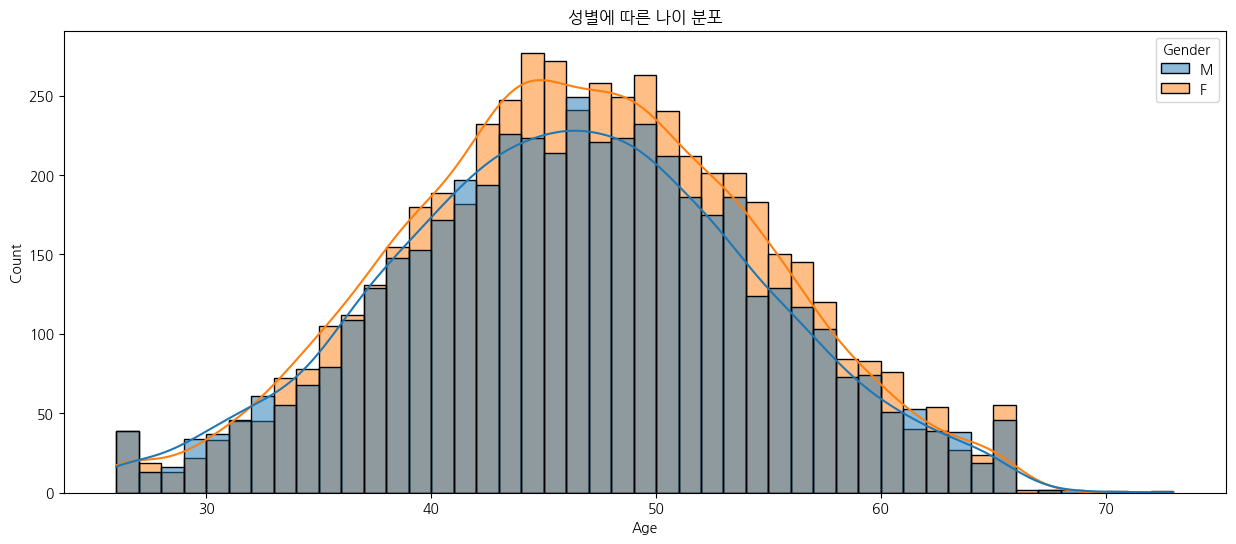

In [ ]:
# age & gender
plt.figure(figsize=(15,6))
plt.title('성별에 따른 나이 분포')
sns.histplot(x='Age', data=df1, hue='Gender', kde=True)
plt.show()

Dependents
- 2 ~ 3명의 부양가족을 가진 고객이 많다.
- 부양가족수에 따른 이탈률을 비교했을 때, 큰 차이가 없다.

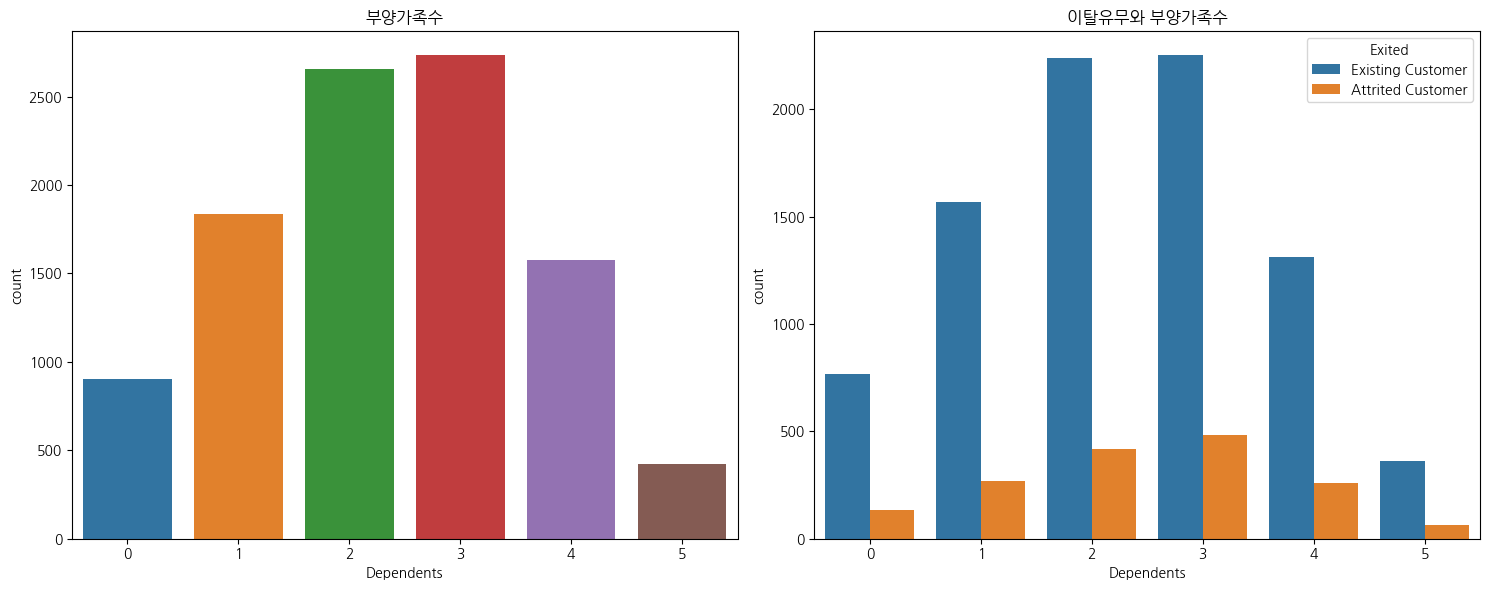

In [ ]:
# 부양가족수
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.title('부양가족수')
sns.countplot(x='Dependents', data=df1)

plt.subplot(1, 2, 2)
sns.countplot(x='Dependents', data=df1, hue='Exited')
plt.title('이탈유무와 부양가족수')
plt.tight_layout()
plt.show()

In [ ]:
# 부양가족수와 이탈률 확인
cross_tab_prop = pd.crosstab(index=df1['Dependents'], columns=df1['Exited'], normalize="index")
cross_tab_prop

Exited,Attrited Customer,Existing Customer
Dependents,,
0,0.149336,0.850664
1,0.146355,0.853645
2,0.157062,0.842938
3,0.176428,0.823572
4,0.165184,0.834816
5,0.150943,0.849057


Education
- 대학을 졸업한 고객이 가장 많다.
- 교육수준에 따른 이탈률도 큰 차이가 없기 때문에 이탈에 영향을 미치지 않는다고 볼 수 있다.

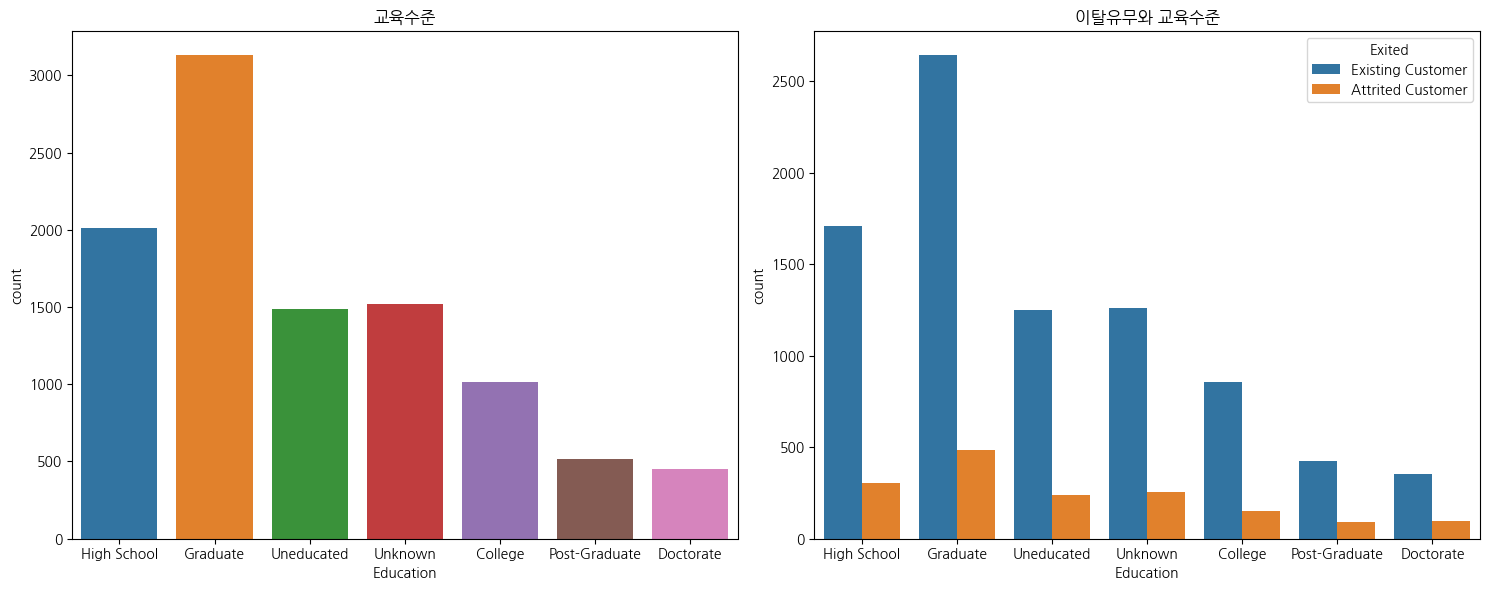

In [ ]:
# Education
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.title('교육수준')
sns.countplot(x='Education', data=df1)

plt.subplot(1, 2, 2)
sns.countplot(x='Education', data=df1, hue='Exited')
plt.title('이탈유무와 교육수준')
plt.tight_layout()
plt.show()

In [ ]:
# 교육수준과 이탈률 확인
cross_tab_prop = pd.crosstab(index=df1['Education'], columns=df1['Exited'], normalize="index")
cross_tab_prop

Exited,Attrited Customer,Existing Customer
Education,,
College,0.152024,0.847976
Doctorate,0.210643,0.789357
Graduate,0.155691,0.844309
High School,0.152012,0.847988
Post-Graduate,0.178295,0.821705
Uneducated,0.159381,0.840619
Unknown,0.168532,0.831468


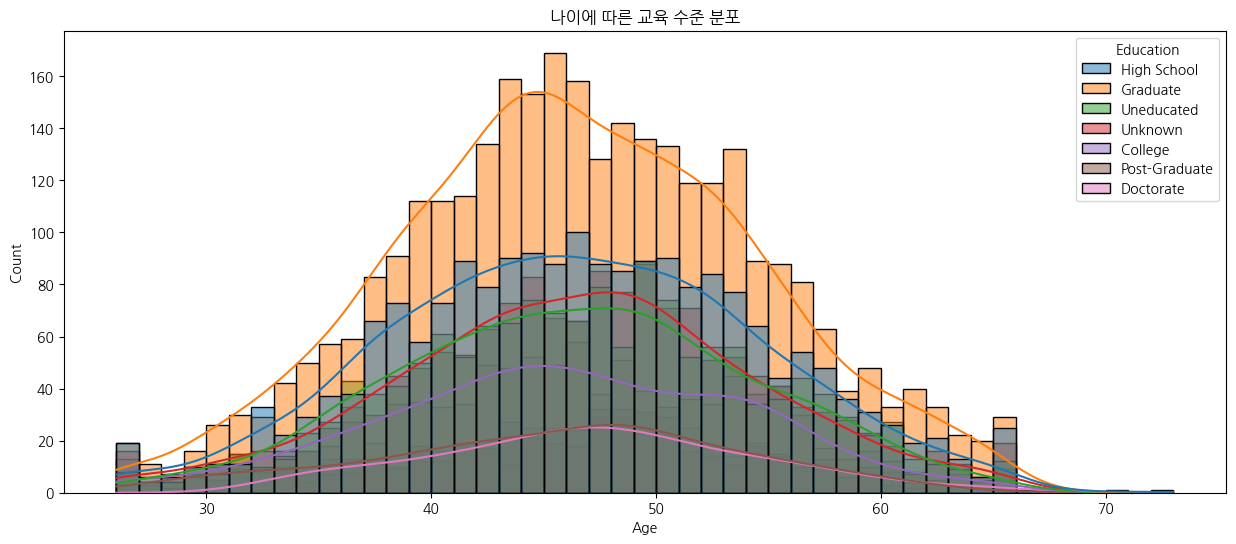

In [ ]:
# age & education
plt.figure(figsize=(15,6))
plt.title('나이에 따른 교육 수준 분포')
sns.histplot(x='Age', data=df1, hue='Education', kde=True)
plt.show()

Marital
- 결혼유무가 이탈률에 큰 영향을 미치지 않는다.

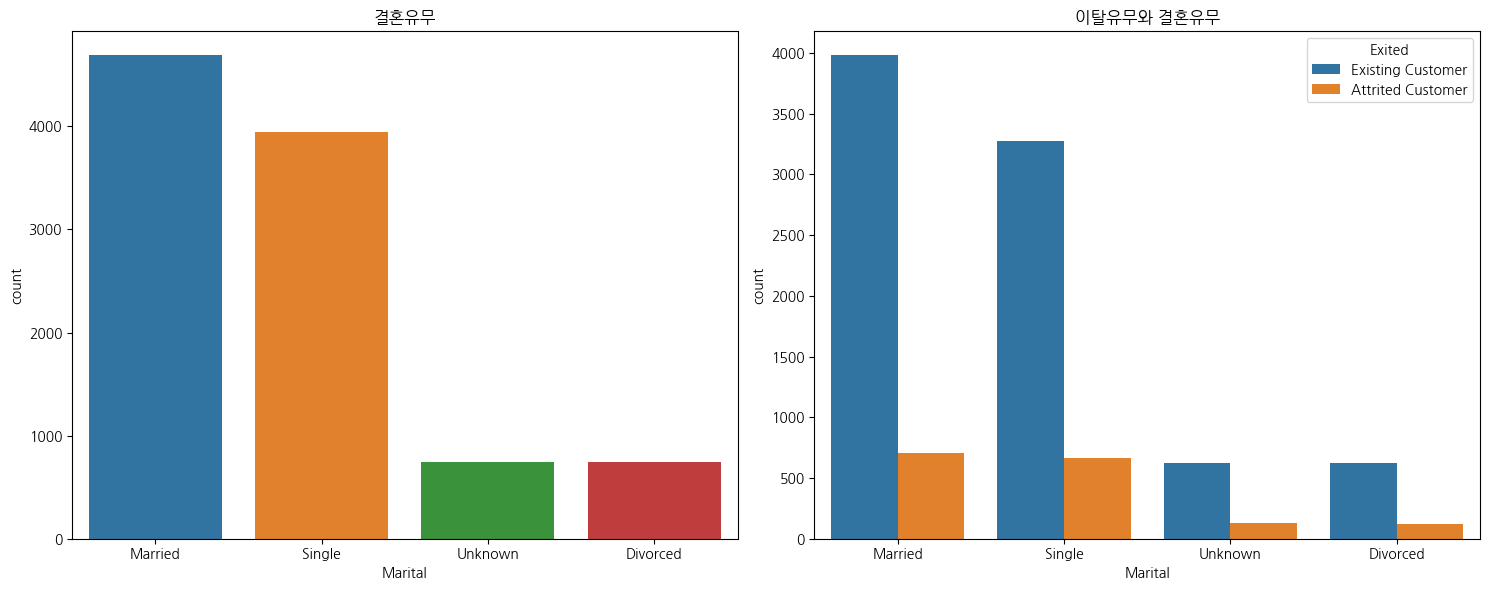

In [ ]:
# 결혼
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.title('결혼유무')
sns.countplot(x='Marital', data=df1)

plt.subplot(1, 2, 2)
sns.countplot(x='Marital', data=df1, hue='Exited')
plt.title('이탈유무와 결혼유무')
plt.tight_layout()
plt.show()

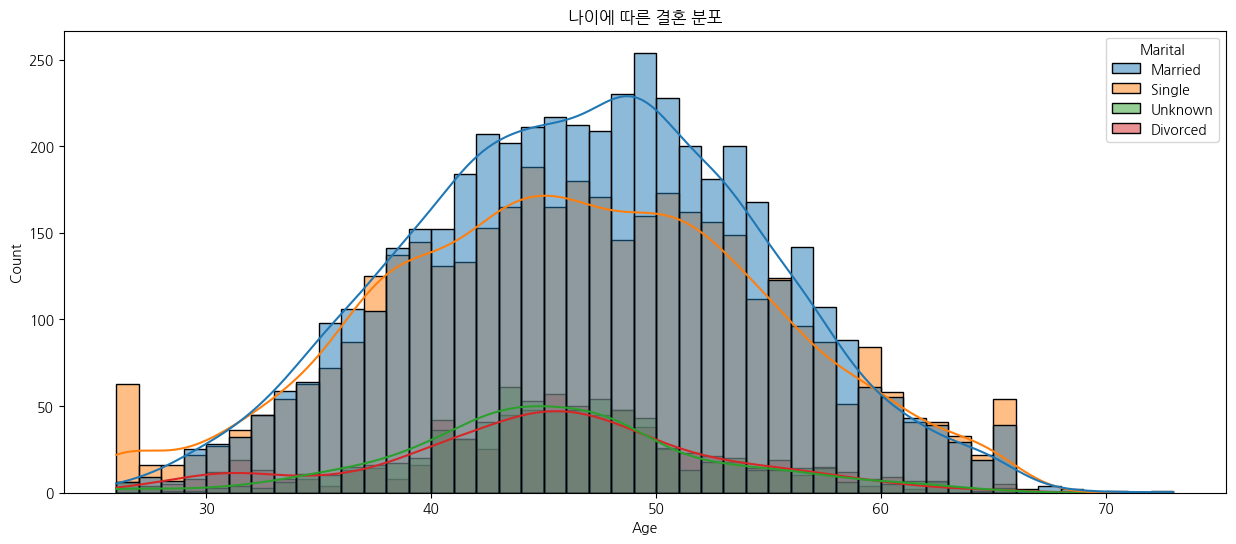

In [ ]:
plt.figure(figsize=(15,6))
plt.title('나이에 따른 결혼 분포')
sns.histplot(x='Age', data=df1, hue='Marital', kde=True)
plt.show()

### EDA 2





Income

In [ ]:
# df copy
df_eda2 = copy.deepcopy(df)

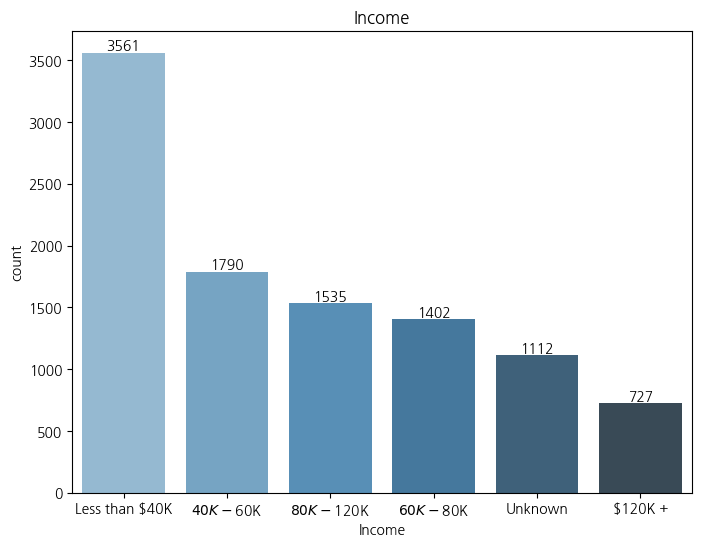

In [ ]:
# Income 컬럼; 가장 많은 카운트로 정렬
plt.figure(figsize=(8, 6))
income_plot = sns.countplot(x='Income', palette='Blues_d', data=df_eda2,  order = df_eda2['Income'].value_counts().index)
for label in income_plot.containers:
    income_plot.bar_label(label)
plt.title('Income')
plt.show()

40k 이하의 소득을 가진 고객들이 은행 고객 중 가장 많음

Text(0.5, 1.0, 'Income Exited or Attrited')

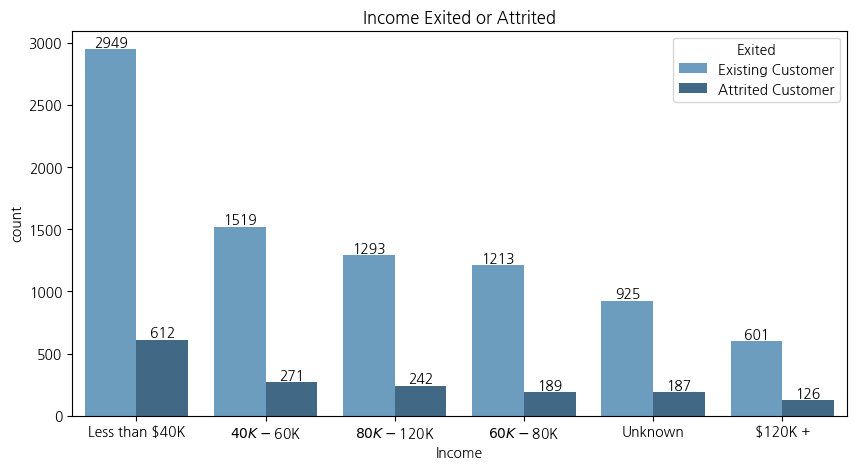

In [ ]:
# Income과 Exited의 관계
plt.figure(figsize=(10,5))
exited_income = sns.countplot(x='Income',data=df_eda2,palette='Blues_d',hue='Exited',order = df_eda2['Income'].value_counts().index)

for label in exited_income.containers:
    exited_income.bar_label(label)
plt.title('Income Exited or Attrited')

In [ ]:
df_exited = df_eda2.copy(deep=True)
df_exited.loc[df_exited['Exited'] == 'Attrited Customer', 'Exited'] = 1
df_exited.loc[df_exited['Exited'] == 'Existing Customer', 'Exited'] = 0

# 이탈 유무를 0, 1로 표현한 데이터 프레임

In [ ]:
# 이탈 비율 확인
churn_rate_income = (df_exited.groupby('Income')['Exited'].mean())*100
print(churn_rate_income)


Income
$120K +           17.331499
$40K - $60K       15.139665
$60K - $80K       13.480742
$80K - $120K      15.765472
Less than $40K    17.186184
Unknown           16.816547
Name: Exited, dtype: float64


Card_Type

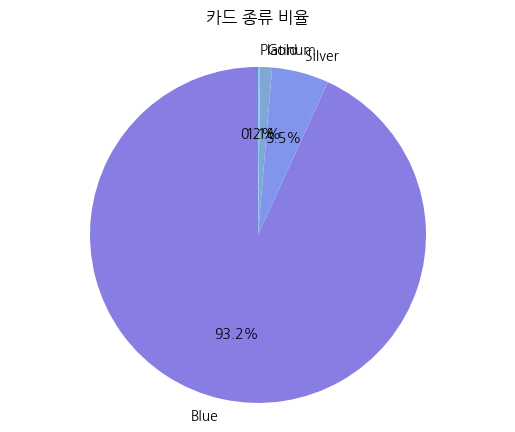

In [ ]:
# 고객이 소지한 카드의 비율을 파이 차트로 나타내기
colors = ['#877DE3', '#8295ED', '#82A7D7','#82CDED']

card_count = df_eda2['Card_Type'].value_counts()
plt.pie(card_count, labels=card_count.index, autopct='%1.1f%%',startangle=90,colors=colors)
plt.axis('equal')
plt.title('카드 종류 비율', pad=20)
plt.show()

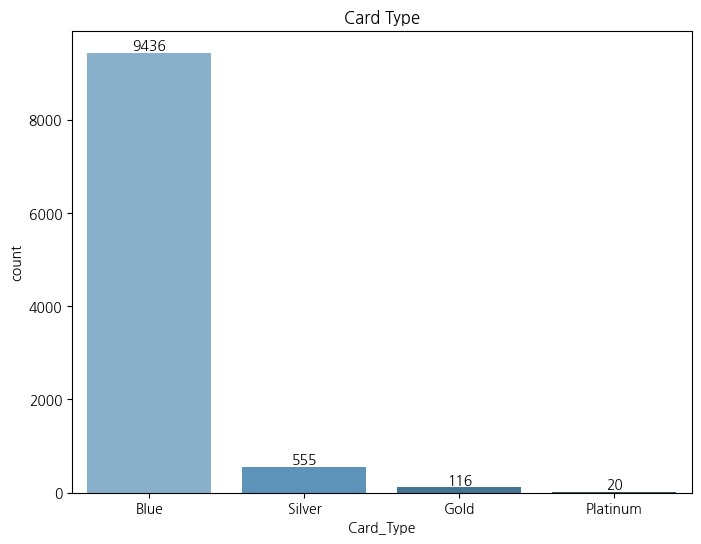

In [ ]:
# Card_Type 컬럼; 가장 많은 카운트로 정렬
plt.figure(figsize=(8, 6))
card_plot = sns.countplot(x='Card_Type', palette='Blues_d', data=df_eda2,  order = df_eda2['Card_Type'].value_counts().index)
for label in card_plot.containers:
    card_plot.bar_label(label)
plt.title('Card Type')
plt.show()

Text(0.5, 1.0, 'Income and Card Type')

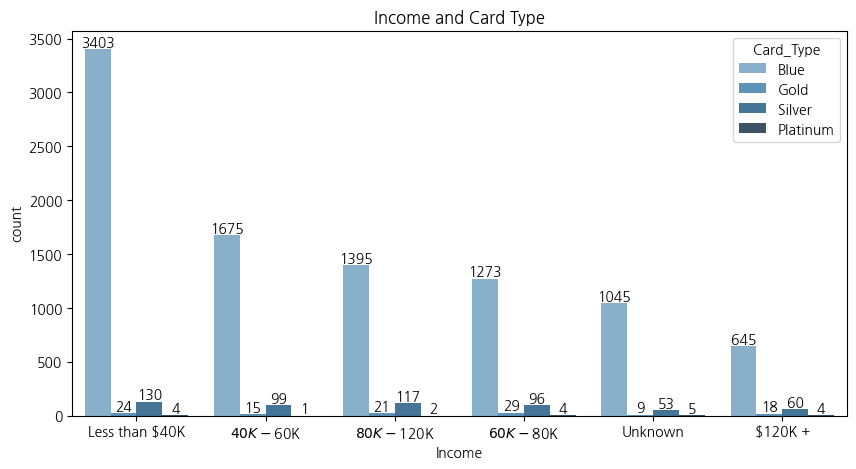

In [ ]:
# Income과 Card Type의 관계
plt.figure(figsize=(10,5))
income_card = sns.countplot(x='Income',data=df_eda2,palette='Blues_d',hue='Card_Type',order = df_eda2['Income'].value_counts().index)

for label in income_card.containers:
    income_card.bar_label(label)
plt.title('Income and Card Type')

Text(0.5, 1.0, 'Card Type: Exited or Attrited')

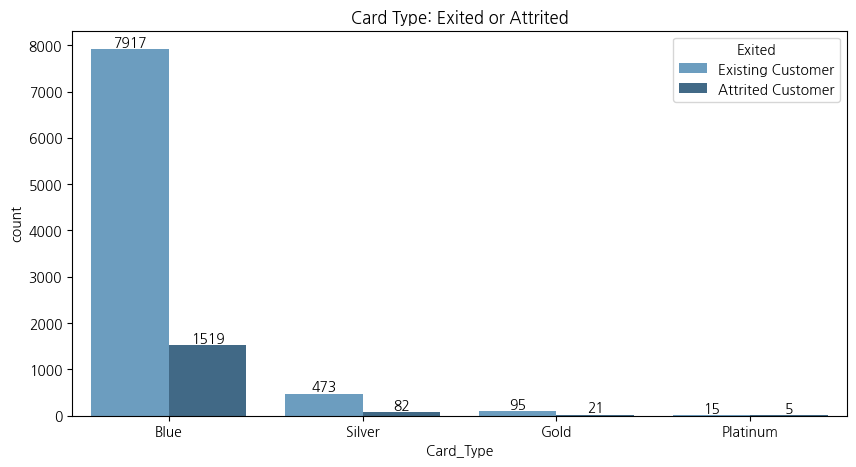

In [ ]:
# 카드 유형과 Exited의 관계
plt.figure(figsize=(10,5))
exited_card = sns.countplot(x='Card_Type',data=df_eda2,palette='Blues_d',hue='Exited',order = df_eda2['Card_Type'].value_counts().index)

for label in exited_card.containers:
    exited_card.bar_label(label)
plt.title('Card Type: Exited or Attrited')

In [ ]:
churn_rate_card = (df_exited.groupby('Card_Type')['Exited'].mean())*100
print(churn_rate_card)

Card_Type
Blue        16.097923
Gold        18.103448
Platinum    25.000000
Silver      14.774775
Name: Exited, dtype: float64


Tenure

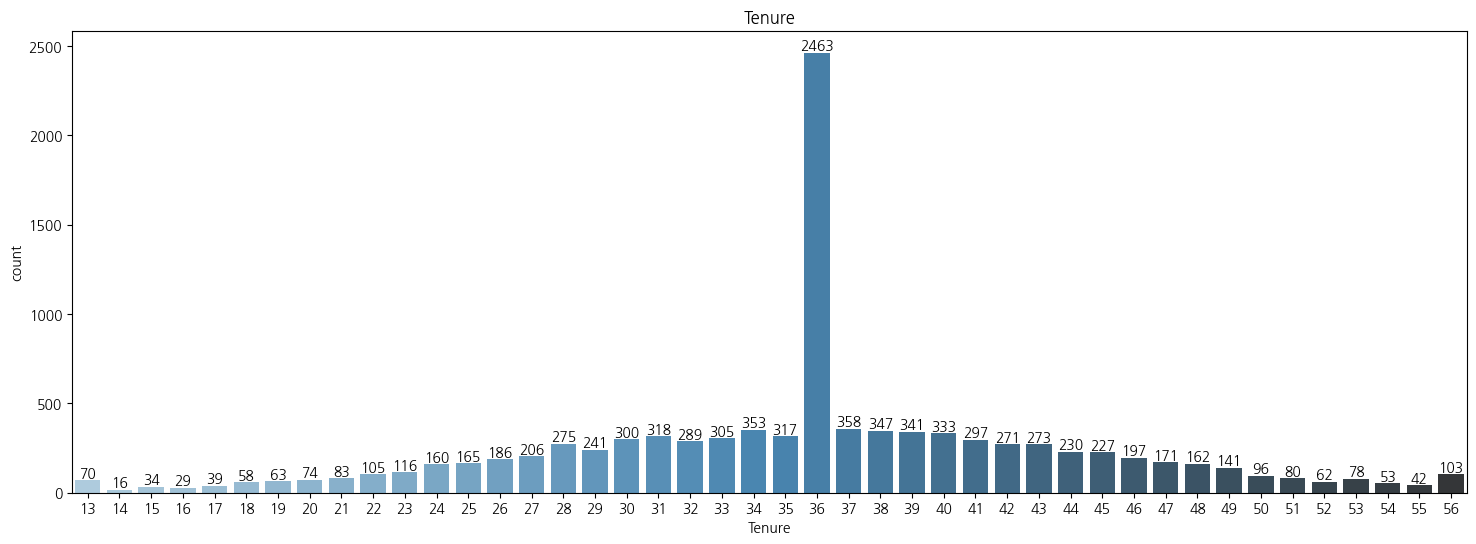

In [ ]:
# Tenure 컬럼; 개월 수 정렬
plt.figure(figsize=(18, 6))
tenure_plot = sns.countplot(x='Tenure', palette='Blues_d', data=df_eda2)
for label in tenure_plot.containers:
    tenure_plot.bar_label(label)
plt.title('Tenure')
plt.show()

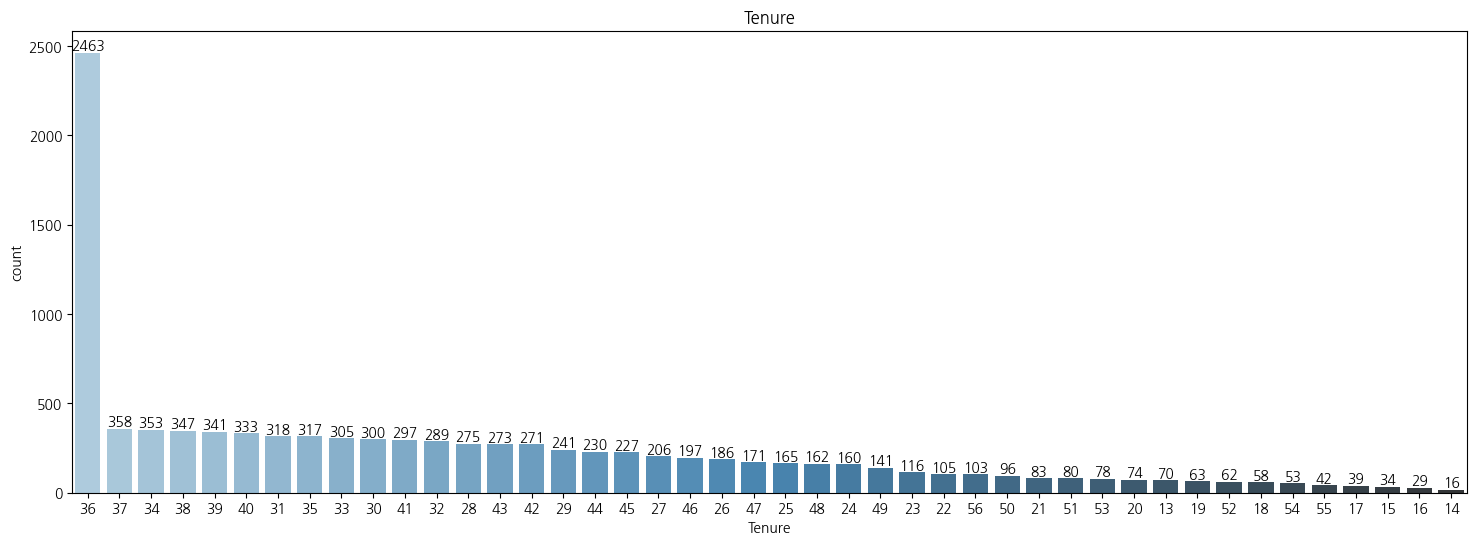

In [ ]:
# Tenure 컬럼; 가장 많은 순 정렬
plt.figure(figsize=(18, 6))
tenure_plot = sns.countplot(x='Tenure', palette='Blues_d', data=df_eda2, order = df_eda2['Tenure'].value_counts().index)
for label in tenure_plot.containers:
    tenure_plot.bar_label(label)
plt.title('Tenure')
plt.show()


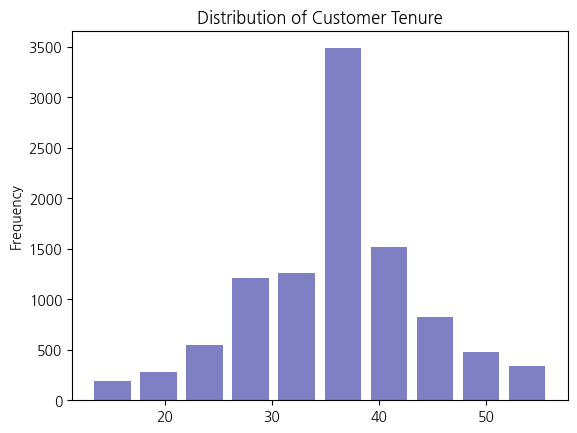

In [ ]:
# 기간 별 고객수를 조금 더 쉽게 보기위해 bin을 이용해서 시각화
plt.hist(df_eda2['Tenure'], bins=10, color = 'darkblue',alpha=0.5, rwidth =0.8 )
plt.ylabel('Frequency')
plt.title('Distribution of Customer Tenure')
plt.show()

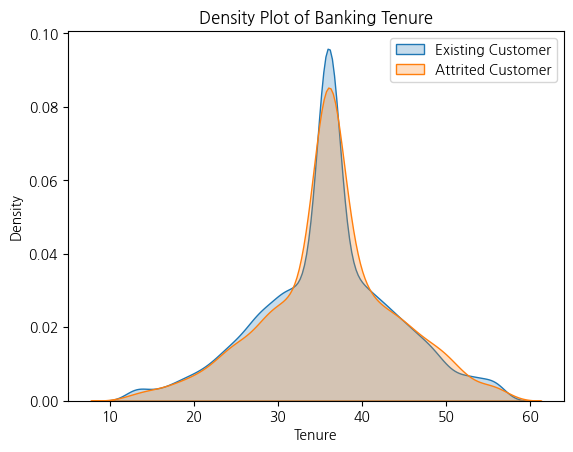

In [ ]:
# 은행 이용 기간 밀도 그래프
existing_customers = df_eda2[df_eda2['Exited'] == 'Existing Customer']['Tenure']
attrited_customers = df_eda2[df_eda2['Exited'] == 'Attrited Customer']['Tenure']

sns.kdeplot(existing_customers, shade=True, label= 'Existing Customer')
sns.kdeplot(attrited_customers, shade=True, label='Attrited Customer')

plt.title('Density Plot of Banking Tenure')
plt.xlabel('Tenure')
plt.ylabel('Density')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Card Type and Tenure')

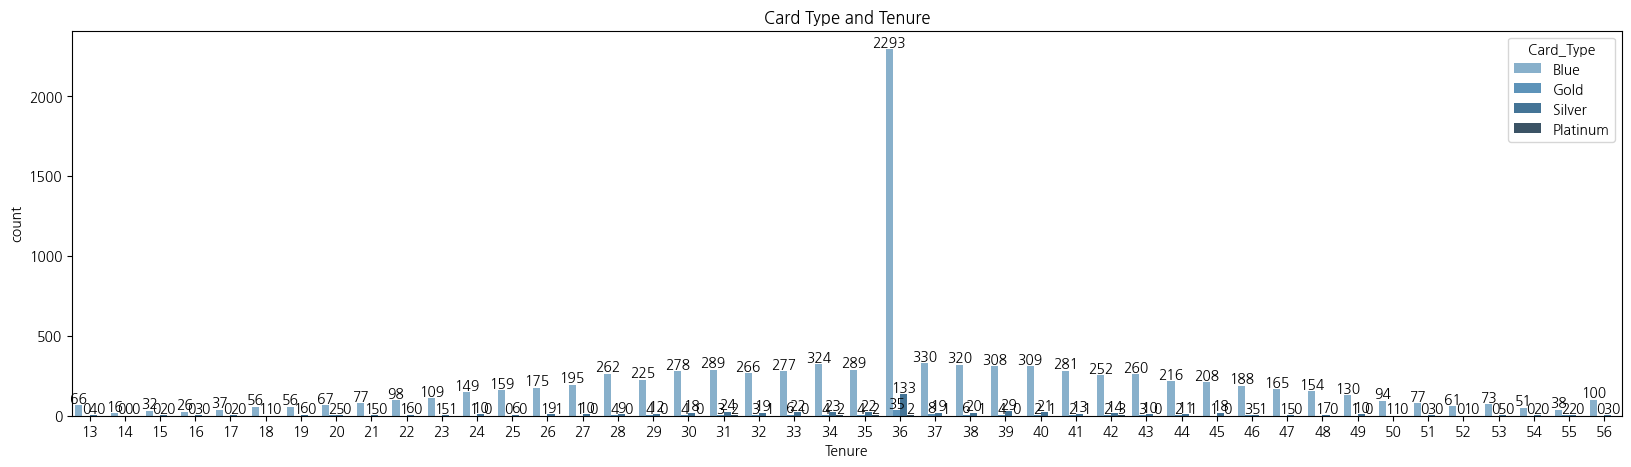

In [ ]:
# 카드 유형과 가입 기간의 관계
plt.figure(figsize=(20,5))
card_tenure = sns.countplot(x='Tenure',data=df_eda2,palette='Blues_d',hue='Card_Type')
for label in card_tenure.containers:
    card_tenure.bar_label(label)
plt.title('Card Type and Tenure')

Product_Cnt

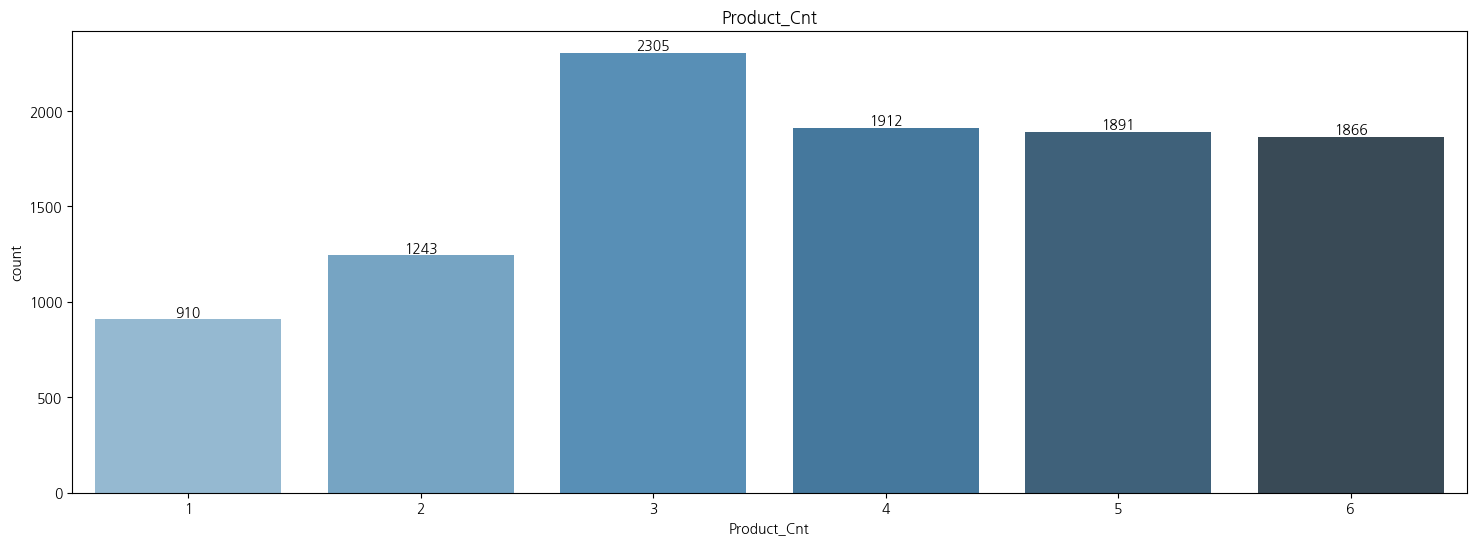

In [ ]:
# Product_Cnt 컬럼
plt.figure(figsize=(18, 6))
product_plot = sns.countplot(x='Product_Cnt', palette='Blues_d', data=df_eda2)
for label in product_plot.containers:
    product_plot.bar_label(label)
plt.title('Product_Cnt')
plt.show()

Text(0.5, 1.0, 'Product_Cnt: Exited or Attrited')

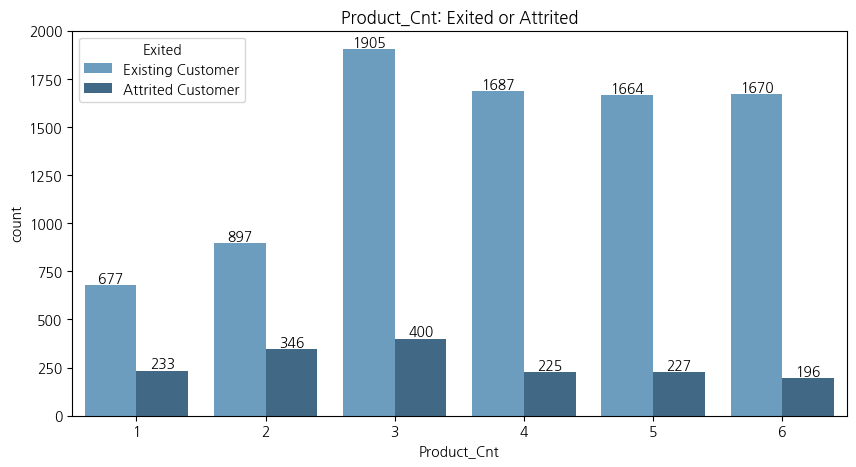

In [ ]:
# Product_Cnt와 Exited의 관계
plt.figure(figsize=(10,5))
product_exited= sns.countplot(x='Product_Cnt',data=df_eda2,palette='Blues_d',hue='Exited')

for label in product_exited.containers:
    product_exited.bar_label(label)
plt.title('Product_Cnt: Exited or Attrited')

Text(0.5, 1.0, 'Product_Cnt: Exited or Attrited')

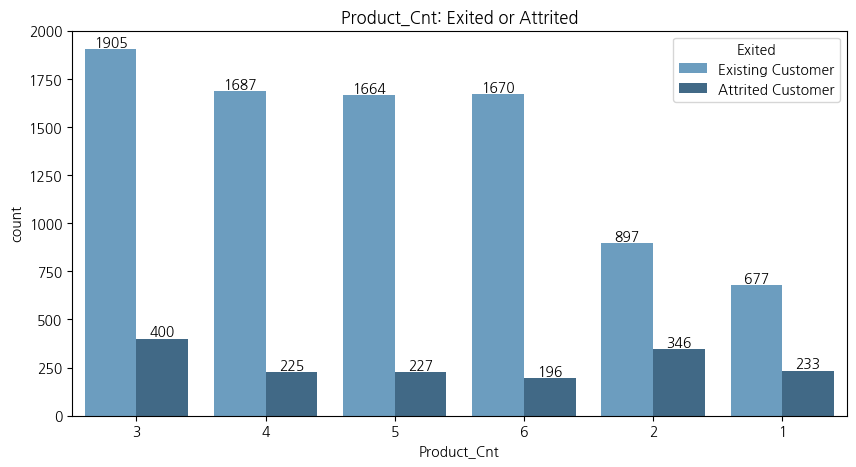

In [ ]:
# Product_Cnt와 Exited의 관계 - 순서 정렬
plt.figure(figsize=(10,5))
product_exited= sns.countplot(x='Product_Cnt',data=df_eda2,palette='Blues_d',hue='Exited',order = df_eda2['Product_Cnt'].value_counts().index)

for label in product_exited.containers:
    product_exited.bar_label(label)
plt.title('Product_Cnt: Exited or Attrited')

Inactive_Months

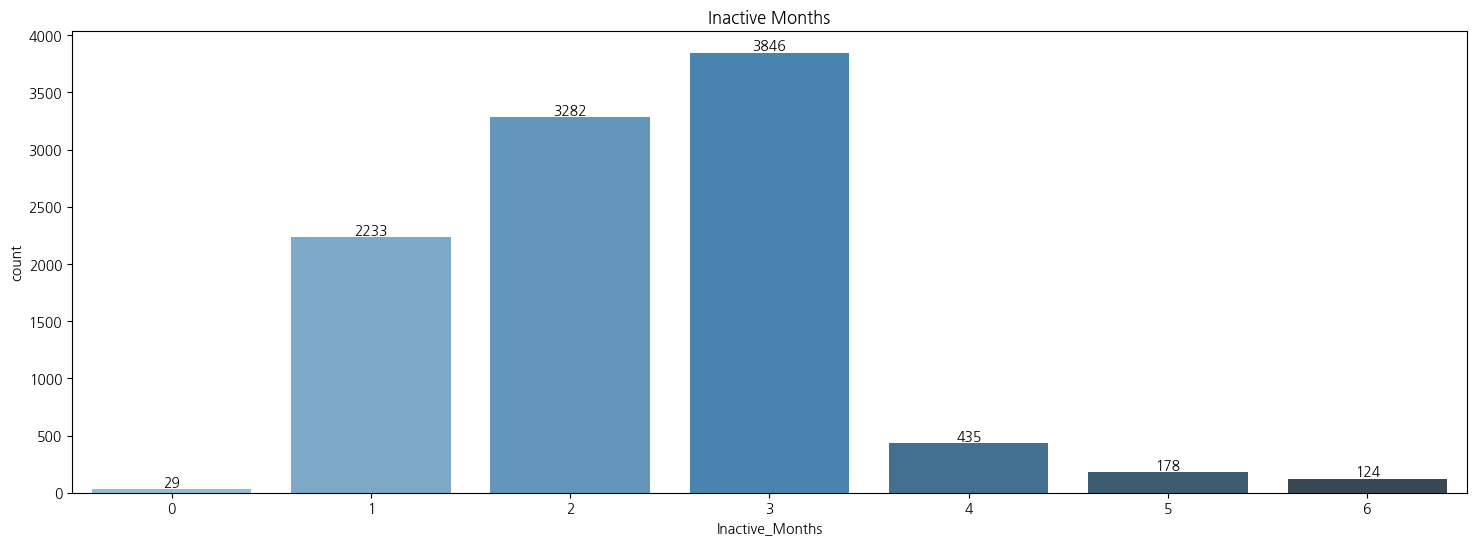

In [ ]:
# Inactive_Months 컬럼
plt.figure(figsize=(18, 6))
inactivate_plot = sns.countplot(x='Inactive_Months', palette='Blues_d', data=df_eda2)
for label in inactivate_plot.containers:
    inactivate_plot.bar_label(label)
plt.title('Inactive Months')
plt.show()

Text(0.5, 1.0, 'Inactive_Months: Exited or Attrited')

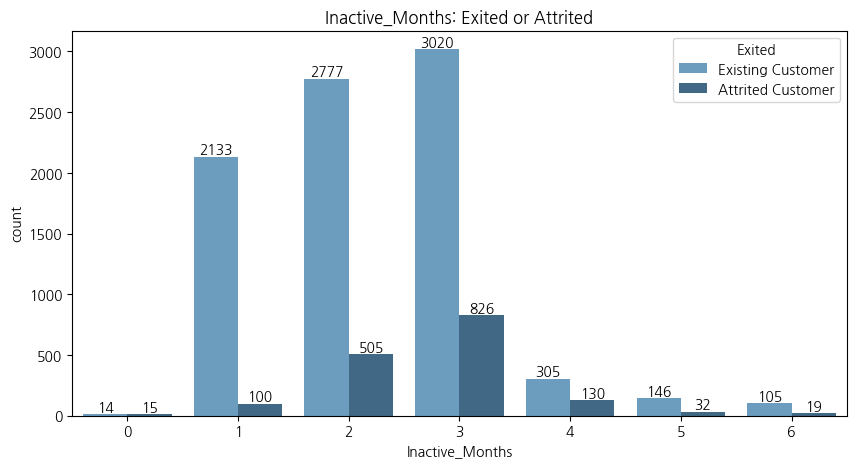

In [ ]:
# Inactive_Months와 Exited의 관계
plt.figure(figsize=(10,5))
inactive_exited= sns.countplot(x='Inactive_Months',data=df_eda2,palette='Blues_d',hue='Exited')

for label in inactive_exited.containers:
    inactive_exited.bar_label(label)
plt.title('Inactive_Months: Exited or Attrited')

Text(0.5, 1.0, 'Inactive Months and Contacts count for customer')

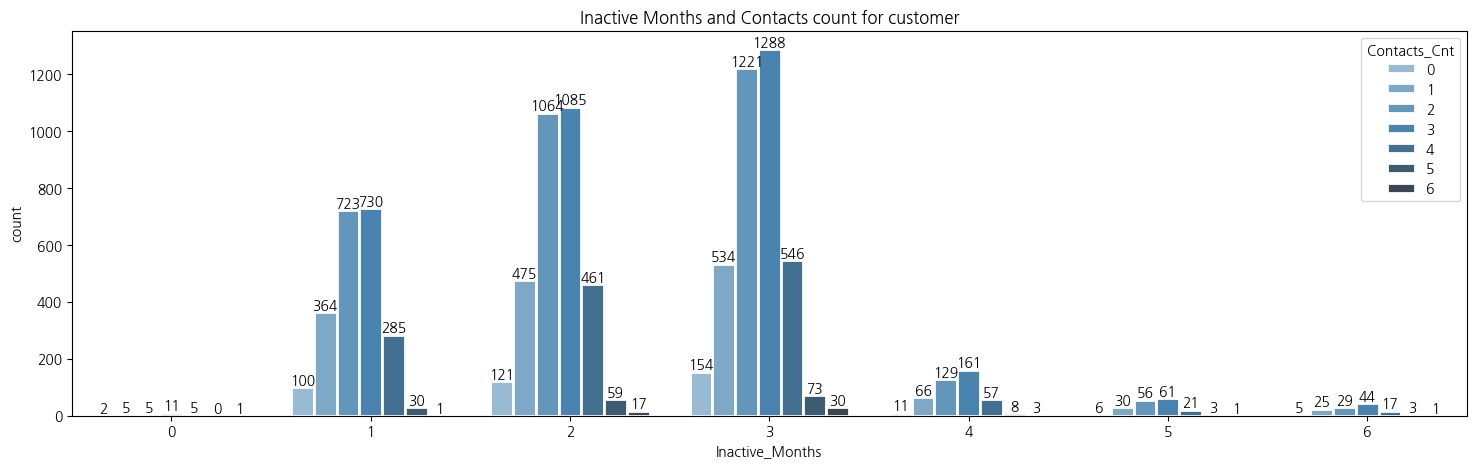

In [ ]:
# 휴면 기간이 길어지면 연락 횟수가 많을까?
plt.figure(figsize=(18,5))
inactive_cnt = sns.countplot(x='Inactive_Months',data=df_eda2,palette='Blues_d',hue='Contacts_Cnt', linewidth = 2, edgecolor = 'white')

for label in inactive_cnt.containers:
    inactive_cnt.bar_label(label)

plt.title('Inactive Months and Contacts count for customer')


#### Contacts_Cnt

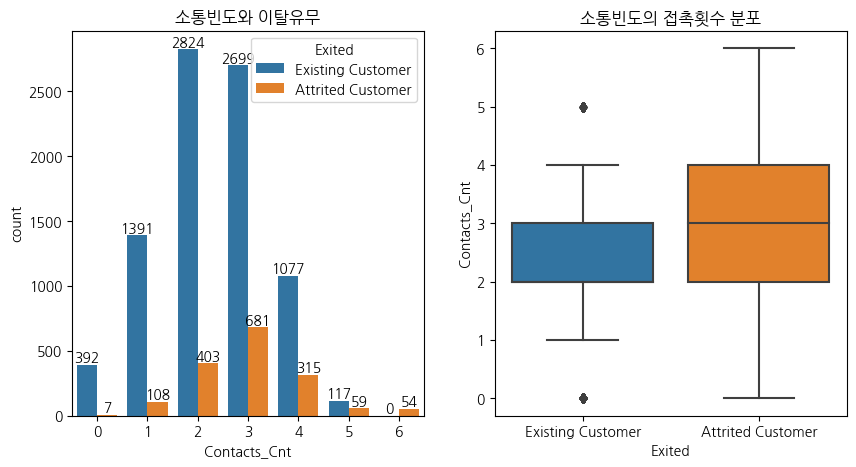

In [ ]:

df_eda3 = copy.deepcopy(df)

fig, ax = plt.subplots(1, 2, figsize= (10, 5))

ax1 = sns.countplot(x='Contacts_Cnt', hue='Exited', data=df_eda3, ax= ax[0])
for label in ax1.containers:
    ax1.bar_label(label)
ax1.set_title('소통빈도와 이탈유무')
ax2 = sns.boxplot(data=df_eda3, y= 'Contacts_Cnt', x= 'Exited', ax= ax[1])
ax2.set_title('소통빈도의 접촉횟수 분포')
plt.show();

# 접촉횟수가 4번인 고객은 1/4 정도가 이탈
# 접촉횟수가 5번인 고객의 1/3 정도가 이탈
# 접촉횟수가 6번인 고객은 전부 이탈
# 접촉횟수가 증가할수록 이탈 비율이 커진다.

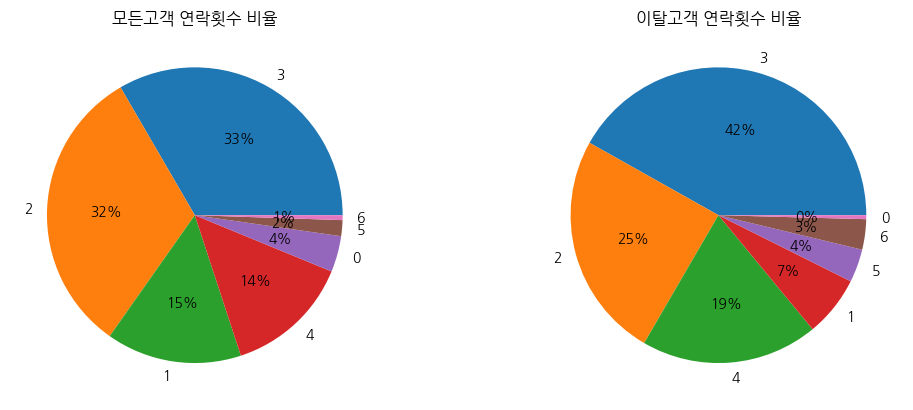

In [ ]:
# 연락횟수, 이탈을 원형 비율로
plt.subplot(1,2,1)
data_counts = df_eda3['Contacts_Cnt'].value_counts()
labels = data_counts.index
counts = data_counts.values
plt.pie(counts, labels=labels,autopct='%.0f%%')
plt.title("모든고객 연락횟수 비율")

plt.subplot(1,2,2)
data_counts = df_eda3[df_eda3['Exited']== 'Attrited Customer']['Contacts_Cnt'].value_counts()
labels = data_counts.index
counts = data_counts.values
plt.pie(counts, labels=labels,autopct='%.0f%%')
plt.title("이탈고객 연락횟수 비율")

plt.subplots_adjust(left = 0.5, right = 2)

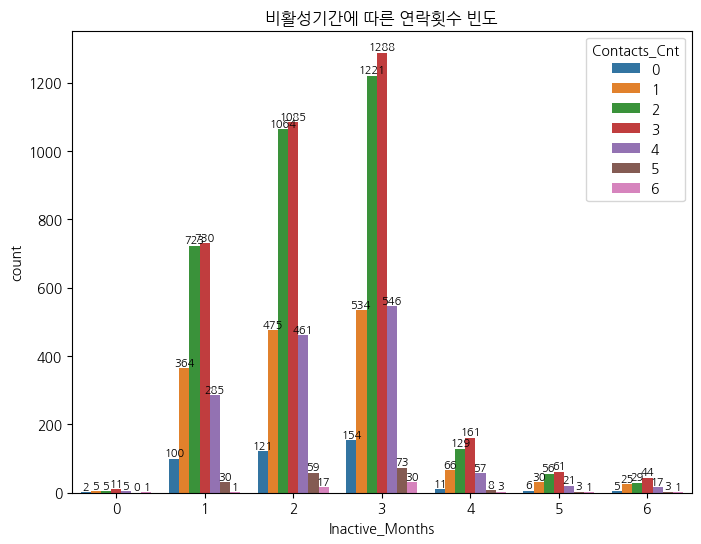

In [ ]:
# 비활성기간에 따른 연락횟수 빈도

plt.figure(figsize=(8, 6))
ax1 = sns.countplot(x='Inactive_Months', hue='Contacts_Cnt', data=df_eda3)
for label in ax1.containers:
    ax1.bar_label(label, fontsize=8)
ax1.set_title('비활성기간에 따른 연락횟수 빈도')
plt.show();

# 비활성기간에 상관없이 연락횟수는 보통 2~3번 정도이다.
# 비활성기간에 따른 연락횟수는 정규분포를 이룬다고 봐도 될 것 같다.

#### Credit_Limit

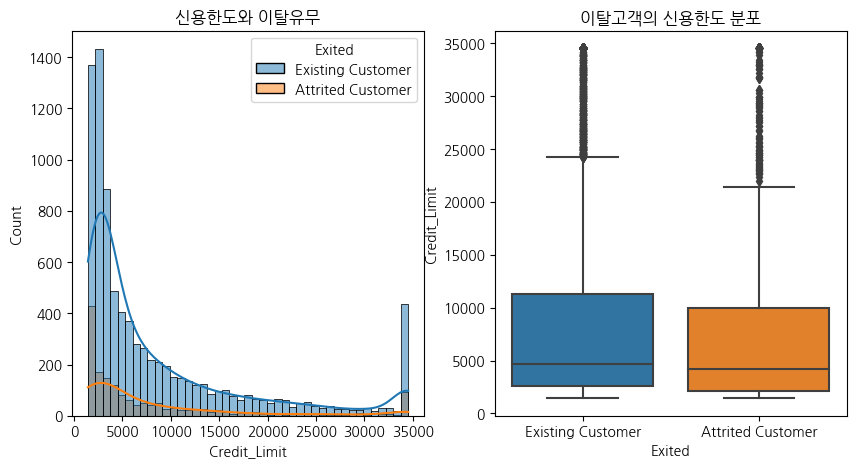

In [ ]:
fig, ax = plt.subplots(1, 2, figsize= (10, 5))

ax1 = sns.histplot(x='Credit_Limit', data=df_eda3, hue='Exited', ax=ax[0], kde=True)
ax1.set_title('신용한도와 이탈유무')

ax2 = sns.boxplot(data= df_eda3, y='Credit_Limit', x= 'Exited', ax= ax[1])
ax2.set_title('이탈고객의 신용한도 분포')
plt.show();

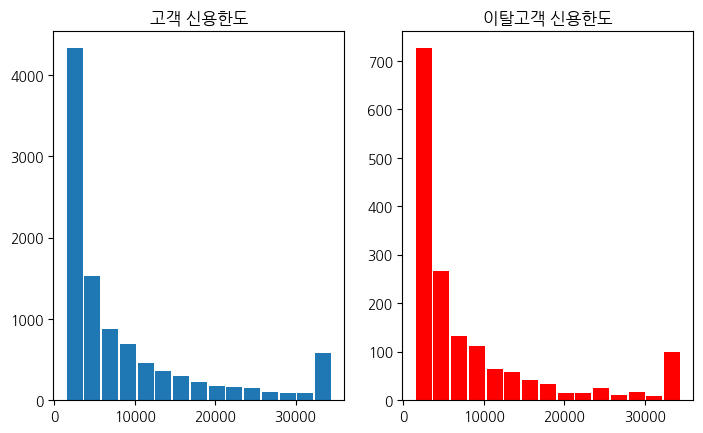

In [ ]:
plt.subplot(1,2,1)
plt.hist(df_eda3['Credit_Limit'], rwidth = 0.9, bins = 15)
plt.title('고객 신용한도')

plt.subplot(1,2,2)
plt.hist(df_eda3[df_eda3['Exited']== 'Attrited Customer']['Credit_Limit'], rwidth = 0.9, color = 'r', bins = 15)
plt.title('이탈고객 신용한도')

plt.subplots_adjust(left = 1, right = 2)

# 전체 고객과 이탈고객의 신용한도는 비슷한 분포를 보인다.

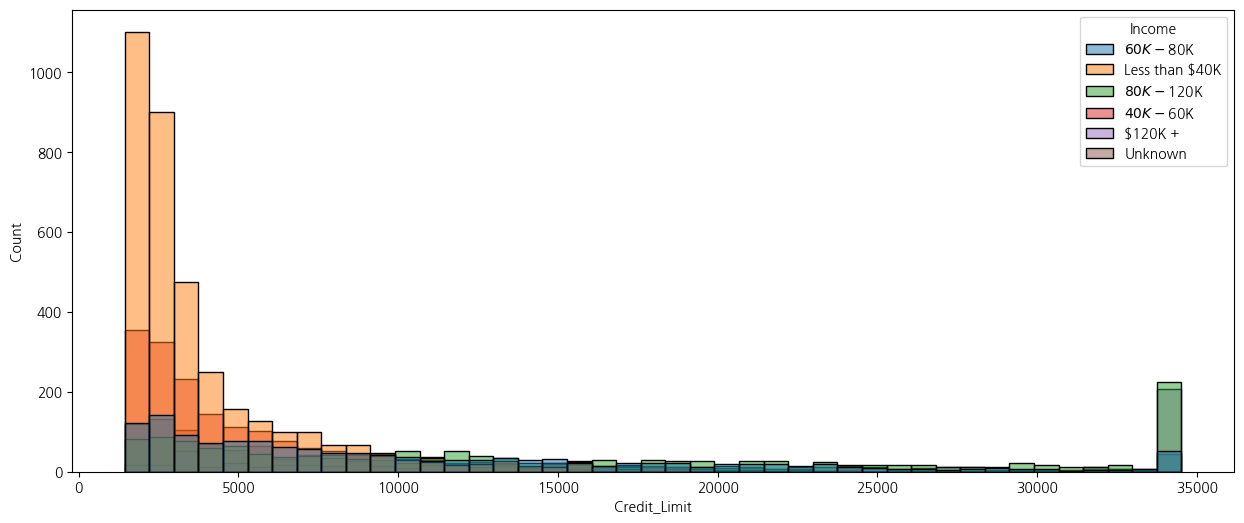

In [ ]:
plt.figure(figsize=(15,6))
sns.histplot(x='Credit_Limit', data=df_eda3, hue='Income')
plt.show();

# 신용한도가 낮을수록 수입이 적어 보이고, 신용한도가 높을수록 수입이 더 많다.

#### Revolv_Bal

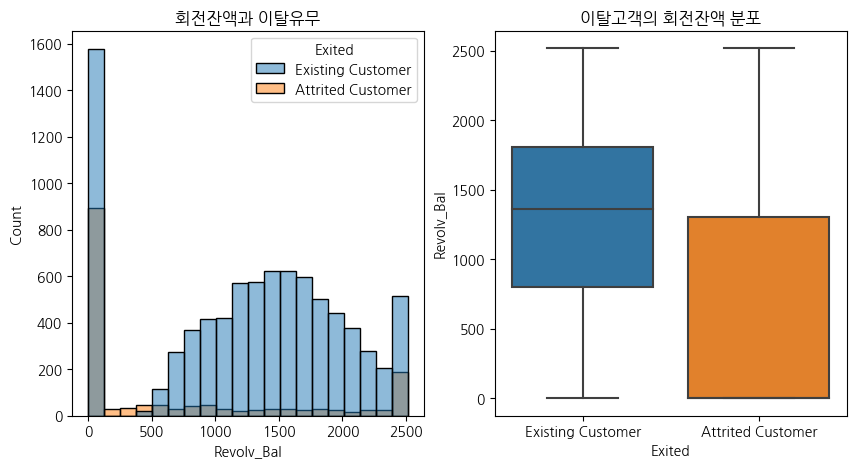

In [ ]:
fig, ax = plt.subplots(1, 2, figsize= (10, 5))

ax1 = sns.histplot(x='Revolv_Bal', data=df_eda3, hue='Exited', ax=ax[0])
ax1.set_title('회전잔액과 이탈유무')

ax2 = sns.boxplot(data=df_eda3, y='Revolv_Bal', x= 'Exited', ax= ax[1])
ax2.set_title('이탈고객의 회전잔액 분포')
plt.show();

# 회전잔액이 0이면 절반정도가 이탈
# 회전잔액이 0~500사이면 이탈하는 고객이 많다.
# 회전잔액이 2500부근에선 약 30% 고객이 이탈


Text(0.5, 1.0, '이탈고객 회전잔액')

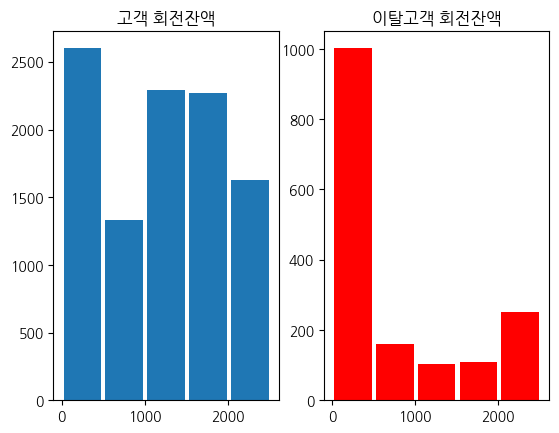

In [ ]:
plt.subplot(1,2,1)
plt.hist(df_eda3['Revolv_Bal'], rwidth = 0.9, bins = 5)
plt.title('고객 회전잔액')

plt.subplot(1,2,2)
plt.hist(df_eda3[df_eda3['Exited']== 'Attrited Customer']['Revolv_Bal'], rwidth = 0.9, color = 'r', bins = 5)
plt.title('이탈고객 회전잔액')

#### Avg_OTB

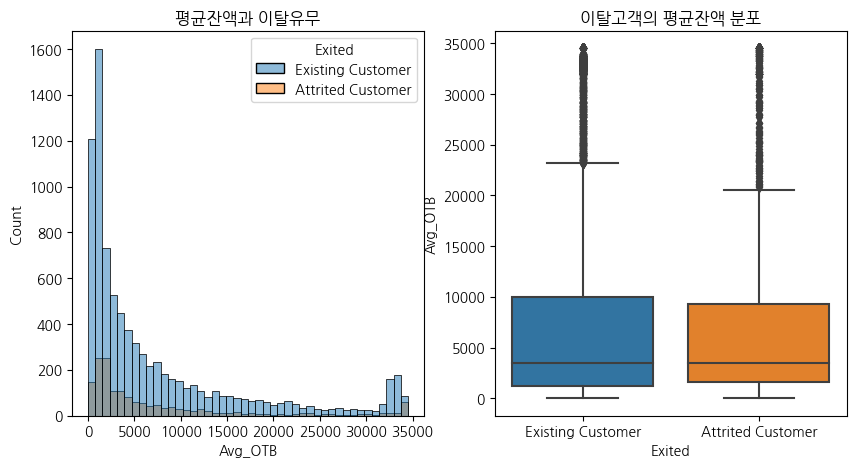

In [ ]:
fig, ax = plt.subplots(1, 2, figsize= (10, 5))

ax1 = sns.histplot(x='Avg_OTB', data=df_eda3, hue='Exited', ax=ax[0])
ax1.set_title('평균잔액과 이탈유무')

ax2 = sns.boxplot(data=df_eda3, y='Avg_OTB', x= 'Exited', ax= ax[1])
ax2.set_title('이탈고객의 평균잔액 분포')
plt.show();

# 평균잔액 3,000 정도에서 약 30%의 이탈률
# 평균잔액 34,000 정도에서 높은 이탈률

['Avg_Util_Ratio', 'Trans_Amt', 'Trans_Cnt', 'Amt_Chng_Q4_Q1', 'Cnt_Chng_Q4_Q1']

In [ ]:
# deep copy
df_eda4 = copy.deepcopy(df)

- Avg_Util_Ratio: 고객의 평균 이용률 비율 (int)

Avg_Util_Ratio는 고객이 신용카드의 사용한 금액과 해당 신용카드의 신용 한도 사이의 비율을 의미합니다.이용률 비율은 고객이 현재 사용 중인 신용 한도에 대해 얼마나 많이 사용하고 있는지를 나타냅니다.

예를 들어, 이용률 비율이 0.5인 경우, 고객은 현재 사용한 신용 한도의 절반을 사용하고 있는 것을 의미합니다. 이용률이 높을수록 고객이 신용 한도를 더 많이 사용하고 있음을 나타내며, 이는 신용 위험을 증가시킬 수 있습니다.

Avg_Util_Ratio는 고객의 신용 이용 패턴과 신용 카드의 활용 정도를 파악하는 데 사용될 수 있습니다. 이를 통해 고객의 신용 상태를 평가하고, 이탈 가능성 예측이나 신용카드 관리 전략 수립에 활용될 수 있습니다. 또한, 이용률 비율을 조정하여 신용 상태를 개선하거나 신용 한도 조정에 대한 결정을 할 수도 있습니다.

In [ ]:
# 최소값과 최대값 찾기
min_urat = df_eda4['Avg_Util_Ratio'].min()
max_urat = df_eda4['Avg_Util_Ratio'].max()

print("최소:", min_urat)
print("최대:", max_urat)

최소: 0.0
최대: 0.999


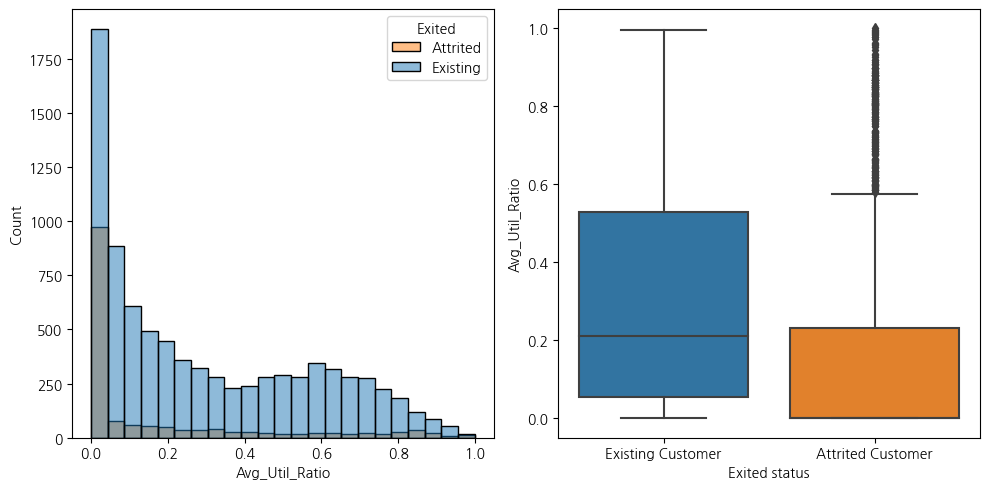

In [ ]:
# boxplot으로 이상치 확인

fig, ax = plt.subplots(1, 2, figsize= (10, 5))

ax1 = sns.histplot(data= df_eda4, x= 'Avg_Util_Ratio', hue= 'Exited', ax= ax[0])

ax1.legend(title= 'Exited', labels= ['Attrited','Existing'])
ax1.set_xlabel('Avg_Util_Ratio')
ax2 = sns.boxplot(data= df_eda4, y= 'Avg_Util_Ratio', x= 'Exited', ax= ax[1])

ax2.set_ylabel('Avg_Util_Ratio')
ax2.set_xlabel('Exited status')

plt.tight_layout()
plt.show()

이탈 고객의 대부분이 평균이용률이 0 이다.

하지만 많은 이상치들이 발견되었다. 이용률이 낮지 않아도 이탈하는 사람들이 있다는 뜻이다.

이는 높은 이용률에도 신용카드 사용에 불만이 있다고 볼 수 있다.

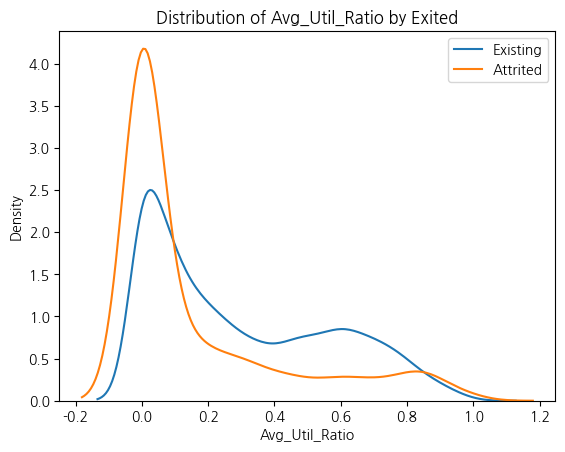

In [ ]:
# 'exist' 그룹의 분포
exist_customers = df_eda4[df_eda4['Exited'] == 'Existing Customer']
sns.kdeplot(data=exist_customers, x='Avg_Util_Ratio', label='Existing')

# 'attrited' 그룹의 분포
attrited_customers = df_eda4[df_eda4['Exited'] == 'Attrited Customer']
sns.kdeplot(data=attrited_customers, x='Avg_Util_Ratio', label='Attrited')

plt.xlabel('Avg_Util_Ratio')
plt.ylabel('Density')
plt.title('Distribution of Avg_Util_Ratio by Exited')
plt.legend()
plt.show()

신용카드 평균 이용률이 낮다는 것은 신용한도를 적게 사용한다는 것을 의미 즉, 고객이 주어진 신용한도 중 일부만을 사용하고 있다는 것을 나타냄.

이용률이 '0'인 경우, 신용카드를 전혀 이용하지 않는 고객일 가능성이 높다. '0' 이용률은 고객이 주어진 신용한도를 전혀 사용하지 않았음을 나타냄.

이는 부채를 가지지 않고, 신용카드 사용에 대한 데이터가 없는 고객일 가능성이 있다.

In [ ]:
len(df_eda4[(df_eda4['Avg_Util_Ratio'] == 0) & (df_eda4['Exited'] == 'Attrited Customer')])

893

In [ ]:
len(df_eda4[(df_eda4['Avg_Util_Ratio'] == 0) & (df_eda4['Exited'] == 'Existing Customer')])

1577

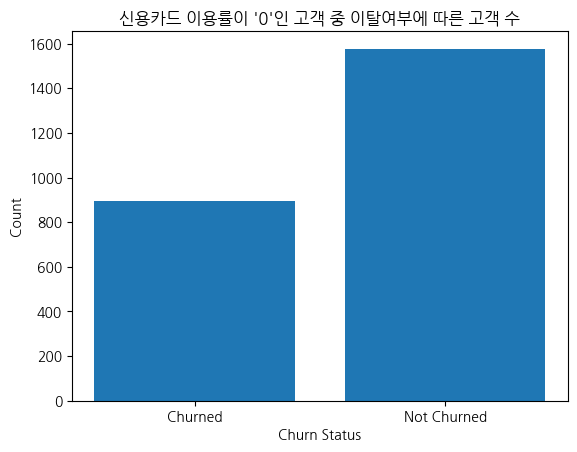

In [ ]:
# 신용카드 이용률이 '0'인 고객 중 이탈여부에 따른 고객 수

# 신용카드 이용률이 '0'인 고객 중 이탈
churned = len(df_eda4[(df_eda4['Avg_Util_Ratio'] == 0) & (df_eda4['Exited'] == 'Attrited Customer')])

# 신용카드 이용률이 '0'인 고객 중 유지
not_churned = len(df_eda4[(df_eda4['Avg_Util_Ratio'] == 0) & (df_eda4['Exited'] == 'Existing Customer')])

# 막대 그래프로 시각화
labels = ['Churned', 'Not Churned']
values = [churned, not_churned]

plt.bar(labels, values)
plt.xlabel('Churn Status')
plt.ylabel('Count')
plt.title("신용카드 이용률이 '0'인 고객 중 이탈여부에 따른 고객 수")
plt.show()

신용카드 이용률이 '0'인 고객 중에서도 이탈하지 않는 고객들이 많다.

따라서 이용률이 '0'인 고객 중 이탈한 고객들은 부채를 가지지 않는 경우인지 분석할 필요가 있다.

- Avg_Util_Ratio & Revolv_Bal

상관관계 분석을 통해서 고객의 부채를 나타내는 Revolv_Bal와 상관관계가 높다는 것을 알아냈다(0.624022)

위의 결과에 따라 부채와의 상관관계 분석을 해보려고 한다.

In [ ]:
# 부채가 0인 경우가 있는지 확인 ('Revolv_Bal' 최소값과 최대값 찾기)
min_bal= df_eda4['Revolv_Bal'].min()
max_bal = df_eda4['Revolv_Bal'].max()

print("최소:", min_bal)
print("최대:", max_bal)

최소: 0
최대: 2517


부채를 가진 사람들/ 가지지 않은 사람들로 나누어서 확인해보려고 함

In [ ]:
debt_customers = df_eda4[df_eda4['Revolv_Bal'] > 0]
no_debt_customers = df_eda4[df_eda4['Revolv_Bal'] == 0]

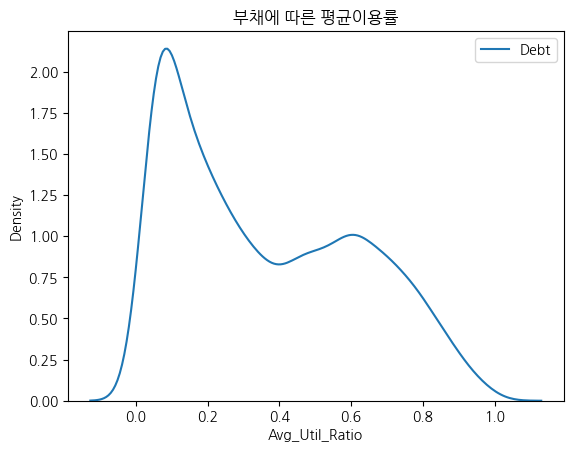

In [ ]:
# 'Revolv_Bal'에 대한 신용카드 평균 이용률 분포

sns.kdeplot(data=debt_customers, x='Avg_Util_Ratio', label='Debt')
sns.kdeplot(data=no_debt_customers, x='Avg_Util_Ratio', label='No Debt')

plt.xlabel('Avg_Util_Ratio')
plt.ylabel('Density')
plt.title('부채에 따른 평균이용률')
plt.legend()
plt.show()

In [ ]:
len(debt_customers)

7657

In [ ]:
len(no_debt_customers)

2470

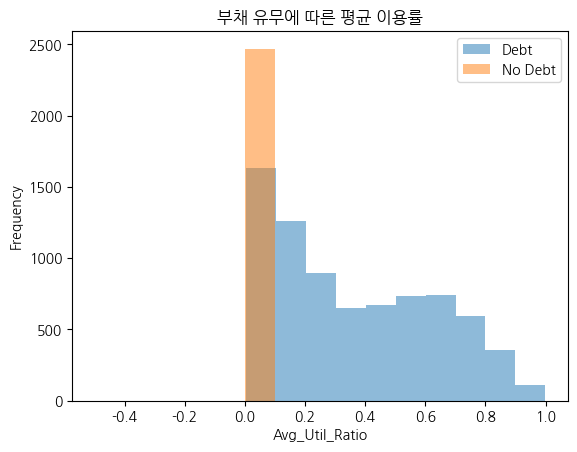

In [ ]:
# 부채 유무에 따른 평균 이용률 histogram

plt.hist(debt_customers['Avg_Util_Ratio'], bins=10, alpha=0.5, label='Debt')
plt.hist(no_debt_customers['Avg_Util_Ratio'], bins=10, alpha=0.5, label='No Debt')

plt.xlabel('Avg_Util_Ratio')
plt.ylabel('Frequency')
plt.title('부채 유무에 따른 평균 이용률')
plt.legend()
plt.show()

In [ ]:
len(no_debt_customers[no_debt_customers['Avg_Util_Ratio'] > 0])

0

In [ ]:
len(no_debt_customers)

2470

부채가 없는 사람들은 신용카드 이용률이 0이다. 하지만 이들 중에서도 이탈하지 않은 고객의 경우가 있다.

그럼 부채가 없는 사람들 중 신용카드 이용률이 0인 사람들((no_debt_customers))은 얼마나 이탈했을까?

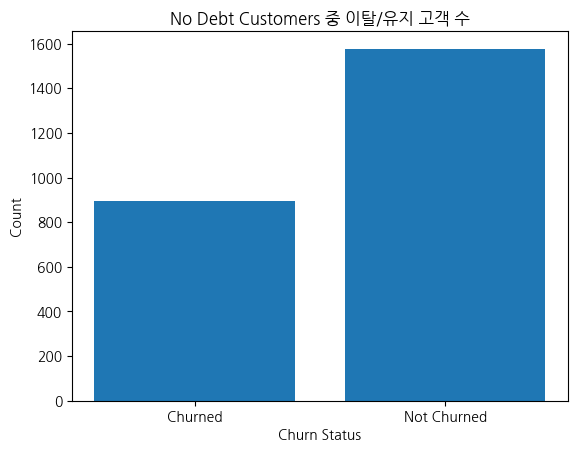

In [ ]:
# 부채가 없고 이용률도 없는 고객(no_debt_customers) 중 이탈 분석

churned_customers = no_debt_customers[no_debt_customers['Exited'] == 'Attrited Customer']
not_churned_customers = no_debt_customers[no_debt_customers['Exited'] == 'Existing Customer']

churned_count = len(churned_customers)
not_churned_count = len(not_churned_customers)

labels = ['Churned', 'Not Churned']
values = [churned_count, not_churned_count]

plt.bar(labels, values)
plt.xlabel('Churn Status')
plt.ylabel('Count')
plt.title('No Debt Customers 중 이탈/유지 고객 수')
plt.show()

In [ ]:
# 평균이용률이 0인 사람 중 이탈한 사람 수
len(df_eda4[(df_eda4['Avg_Util_Ratio'] == 0) & (df_eda4['Exited'] == 'Attrited Customer')])

893

In [ ]:
# 부채가 없는 경우(평균 이용률도 없음) 이탈한 사람 수
len(no_debt_customers[no_debt_customers['Exited'] == 'Attrited Customer'])

893

In [ ]:
len(no_debt_customers[no_debt_customers['Exited'] == 'Existing Customer'])

1577

부채가 없는 경우는 모두 평균이용률이 '0' 이었다.
평균이용률이 0인 고객중 이탈한 사람 수와 부채가 없는 경우 이탈한 사람 수를 비교해보니 그 수가 같았다.

따라서 이용률이 '0'인 고객 중 이탈한 고객들은 부채를 가지지 않는 경우라고 할 수 있다.

하지만 부채가 없고, 신용카드 평균 이용률이 0 인 고객이 반드시 이탈한 것은 아니다.(1600명 가량)

부채가 있는 사람 중 낮은 이용률인 사람들이 있다.
그럼 낮은 이용률인 고객들은 부채를 얼마나 가지고 있을까?

In [ ]:
len(debt_customers[debt_customers['Avg_Util_Ratio'] < 0.3])

3776

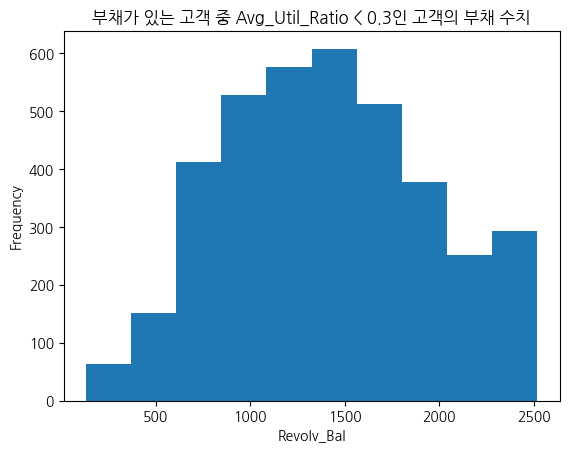

In [ ]:
# 부채가 있는 사람 중 낮은 이용률인 고객들의 보유 부채

debt_customers_of_urat = debt_customers[debt_customers['Avg_Util_Ratio'] < 0.3]

plt.hist(debt_customers_of_urat['Revolv_Bal'], bins=10)
plt.xlabel('Revolv_Bal')
plt.ylabel('Frequency')
plt.title('부채가 있는 고객 중 Avg_Util_Ratio < 0.3인 고객의 부채 수치')
plt.show()

낮은 이용률에도 부채가 높은 사람들이 꽤 많다.

- Avg_Util_Ratio & Avg_OTB

상관관계 분석을 통해서 Avg_OTB(고객의 평균잔액)와 상관관계가 높다는 것을 알아냈다(-0.538808)

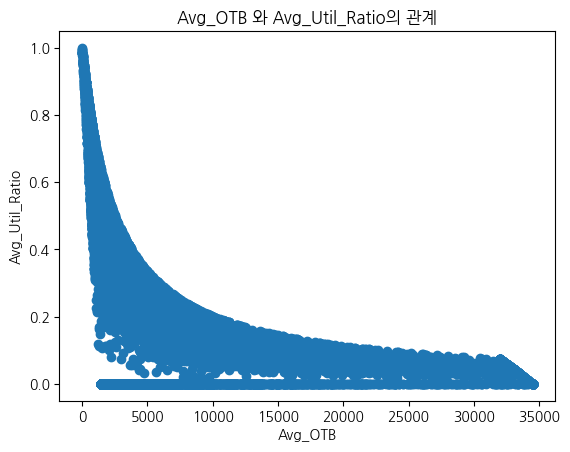

In [ ]:
plt.scatter(df_eda4['Avg_OTB'], df_eda4['Avg_Util_Ratio'])
plt.xlabel('Avg_OTB')
plt.ylabel('Avg_Util_Ratio')
plt.title('Avg_OTB 와 Avg_Util_Ratio의 관계')
plt.show()

Avg_OTB가 높을수록 Avg_Util_Ratio는 낮아지는 경향을 보임.

Avg_OTB가 높을수록 고객이 아직 사용하지 않은 신용한도가 많다는 것을 의미

Avg_Util_Ratio는 신용카드의 평균 이용률로, 고객이 현재 사용 중인 신용한도의 비율을 나타냄.
따라서, Avg_Util_Ratio가 낮을수록 고객은 현재의 신용한도 중에서 적은 비율을 사용하고 있다는 것을 의미합니다.

따라서, Avg_OTB가 증가하면 고객이 아직 사용하지 않은 신용한도가 많아지므로 Avg_Util_Ratio가 감소하는 경향을 보인다.

- Avg_Util_Ratio & Credit_Limit(신용 한도)

상관관계 분석을 통해서 Credit_Limit(신용 한도)와 상관관계가 높다는 것을 알아냈다(-0.482965)

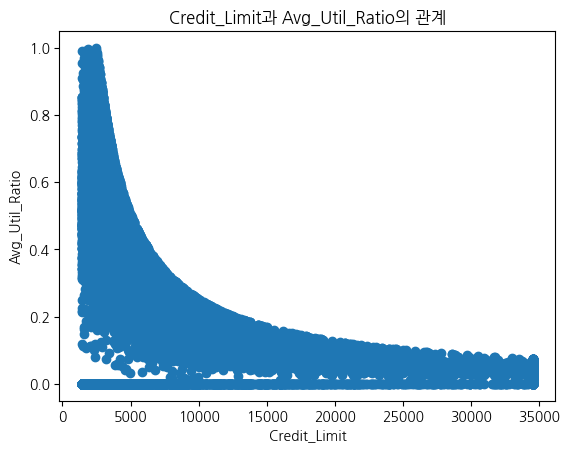

In [ ]:
plt.scatter(df_eda4['Credit_Limit'], df_eda4['Avg_Util_Ratio'])
plt.xlabel('Credit_Limit')
plt.ylabel('Avg_Util_Ratio')
plt.title('Credit_Limit과 Avg_Util_Ratio의 관계')
plt.show()

Credit_Limit이 낮을수록 Avg_Util_Ratio는 높아지는 경향을 보임

Avg_Util_Ratio가 높다는 것은 고객이 신용 한도를 더 많이 사용하고 있음을 의미

- 신용한도가 적은데 이용률이 높다는게 무슨 의미일까?

신용한도가 적은데 이용률이 높다는 것은 고객이 할당받은 신용한도를 상당 부분 사용하고 있다는 의미입니다. 일반적으로 신용한도가 적을수록 신용카드를 더 많이 사용하고 있다는 것을 나타냅니다.

이러한 상황은 몇 가지 가능한 의미를 가질 수 있습니다:

1. 큰 소득 대비 큰 소비: 고객의 소득 수준에 비해 신용한도가 적지만, 고객이 큰 비율로 신용한도를 사용하는 경우입니다. 이는 해당 고객이 높은 소득을 가지고 있거나, 다른 금융 자산을 보유하고 있어서 추가적인 신용 한도를 얻을 필요가 없는 상황일 수 있습니다.

2. 긴급한 재정 상황: 신용한도가 적은데 이용률이 높은 경우, 해당 고객이 긴급한 재정 상황에 처한 상황일 수 있습니다. 예를 들어, 예기치 않은 긴급한 지출 또는 재정적 어려움으로 인해 신용카드를 사용하여 재정 상황을 해결하려는 경우일 수 있습니다.

3. 신용부채 상태: 고객이 다른 금융 제품에서 발생한 부채를 상환하기 위해 신용카드를 사용하는 경우입니다. 신용한도가 적은데 이용률이 높은 상황은 다른 부채를 상환하기 위해 신용카드를 활용하고 있으며, 이로 인해 신용카드의 신용한도를 더 많이 사용하는 것일 수 있습니다.

Trans_Amt: 총 거래 금액 (int)

고객이 일정 기간 동안 신용카드를 통해 총 얼마나 많은 금액을 소비했는지를 나타냅니다.

총 거래금액이 높을수록 고객은 신용카드를 활발하게 사용하고 큰 금액을 소비하는 경향이 있습니다.

이는 해당 고객이 높은 소비력을 가지고 있다거나, 상대적으로 고가의 상품이나 서비스를 많이 이용하는 등의 특징을 나타낼 수 있습니다.

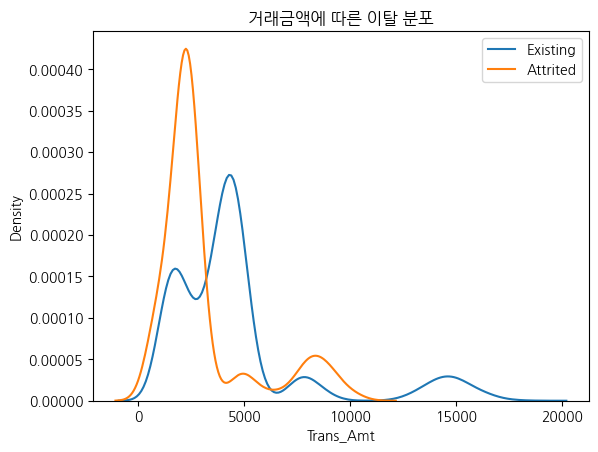

In [ ]:
# 거래금액에 따른 이탈 분포

exist_customers = df_eda4[df_eda4['Exited'] == 'Existing Customer']
attrited_customers = df_eda4[df_eda4['Exited'] == 'Attrited Customer']

sns.kdeplot(data=exist_customers, x='Trans_Amt', label='Existing')
sns.kdeplot(data=attrited_customers, x='Trans_Amt', label='Attrited')

plt.xlabel('Trans_Amt')
plt.ylabel('Density')
plt.title('거래금액에 따른 이탈 분포')
plt.legend()
plt.show()

<Axes: xlabel='Exited', ylabel='Trans_Amt'>

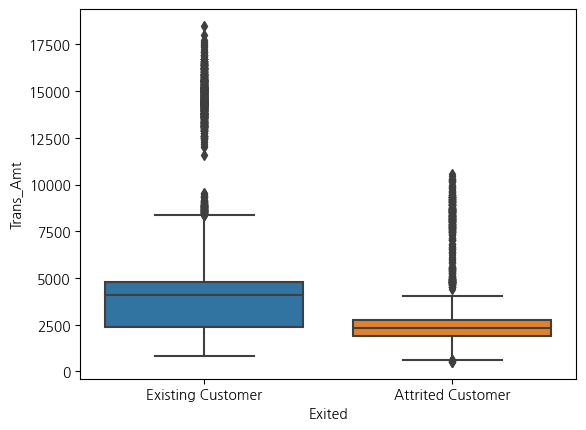

In [ ]:
sns.boxplot(data=df_eda4, x='Exited', y='Trans_Amt')

거래금액이 적을수록 이탈하는 사람 많다

- 총금액/기간으로 해서 소비량을 측정해 이탈과 연관성 분석

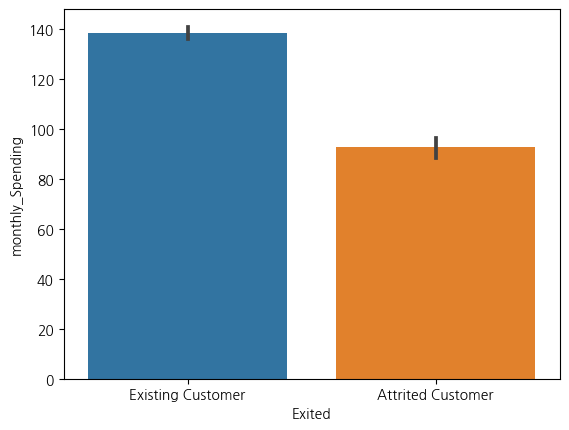

In [ ]:
df_eda4['monthly_Spending'] = df_eda4['Trans_Amt'] / df_eda4['Tenure']

sns.barplot(data=df_eda4, x='Exited', y='monthly_Spending');

<Axes: xlabel='Exited', ylabel='monthly_Spending'>

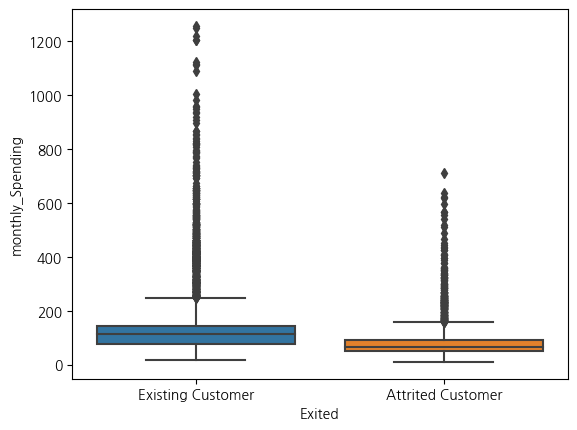

In [ ]:
sns.boxplot(data=df_eda4, x='Exited', y='monthly_Spending')

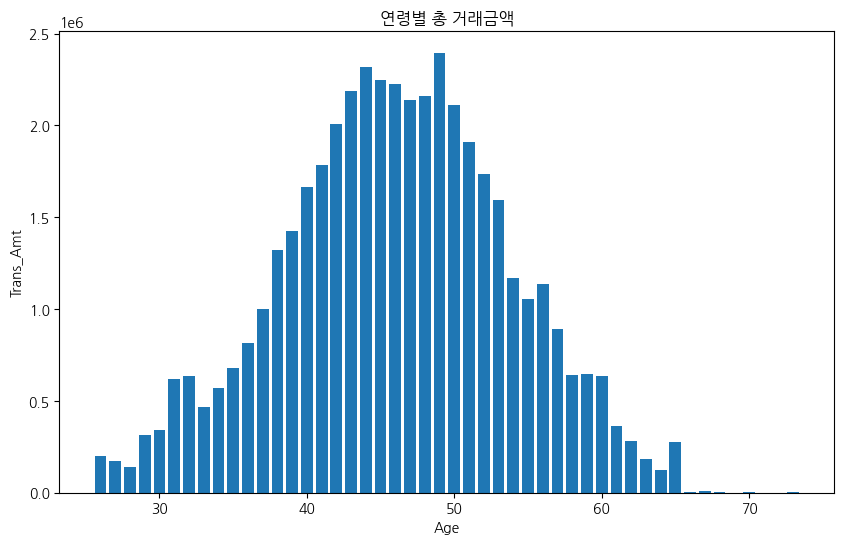

In [ ]:
# 연령별 총 거래금액

age_total_amount =df_eda4.groupby('Age')['Trans_Amt'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(age_total_amount['Age'], age_total_amount['Trans_Amt'])
plt.xlabel('Age')
plt.ylabel('Trans_Amt')
plt.title('연령별 총 거래금액')
plt.show()

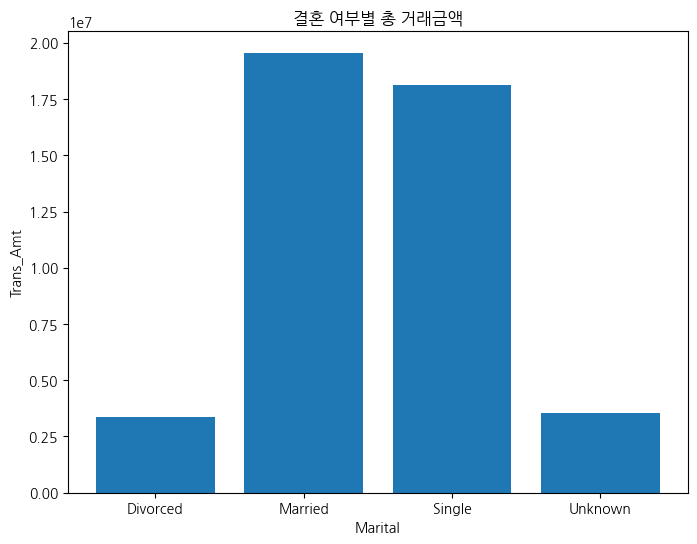

In [ ]:
# 결혼 여부별 총 거래금액 계산

marital_total_amount = df_eda4.groupby('Marital')['Trans_Amt'].sum().reset_index()

plt.figure(figsize=(8, 6))
plt.bar(marital_total_amount['Marital'], marital_total_amount['Trans_Amt'])
plt.xlabel('Marital')
plt.ylabel('Trans_Amt')
plt.title('결혼 여부별 총 거래금액')
plt.show()

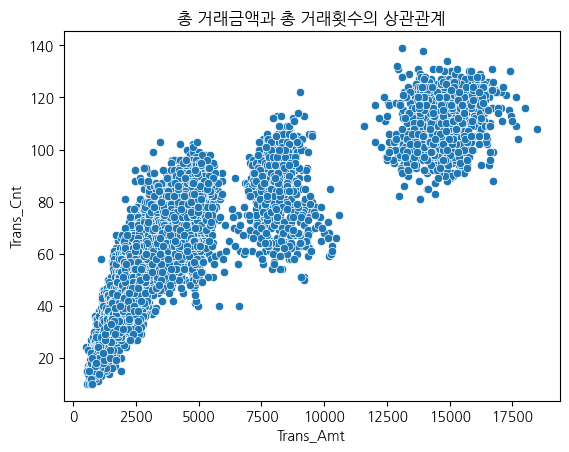

In [ ]:
# 총 거래금액과 총 거래횟수의 상관관계
sns.scatterplot(data=df_eda4, x='Trans_Amt', y='Trans_Cnt')
plt.xlabel('Trans_Amt')
plt.ylabel('Trans_Cnt')
plt.title('총 거래금액과 총 거래횟수의 상관관계')
plt.show()

Trans_Cnt: 총 거래 횟수 (int)

고객이 일정 기간 동안 신용카드를 통해 총 몇 번이나 거래를 수행했는지를 나타냅니다.

총 거래횟수가 높을수록 고객은 더 많은 횟수로 신용카드를 사용하고 있는 것을 의미합니다.

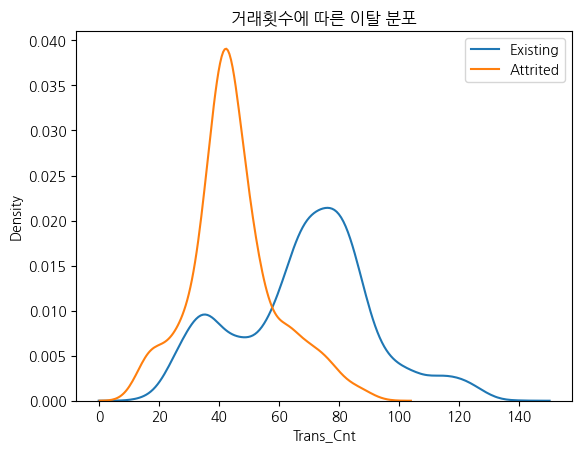

In [ ]:
# 거래횟수에 따른 이탈 분포

exist_customers = df_eda4[df_eda4['Exited'] == 'Existing Customer']
attrited_customers = df_eda4[df_eda4['Exited'] == 'Attrited Customer']

sns.kdeplot(data=exist_customers, x='Trans_Cnt', label='Existing')
sns.kdeplot(data=attrited_customers, x='Trans_Cnt', label='Attrited')

plt.xlabel('Trans_Cnt')
plt.ylabel('Density')
plt.title('거래횟수에 따른 이탈 분포')
plt.legend()
plt.show()

<Axes: xlabel='Exited', ylabel='Trans_Cnt'>

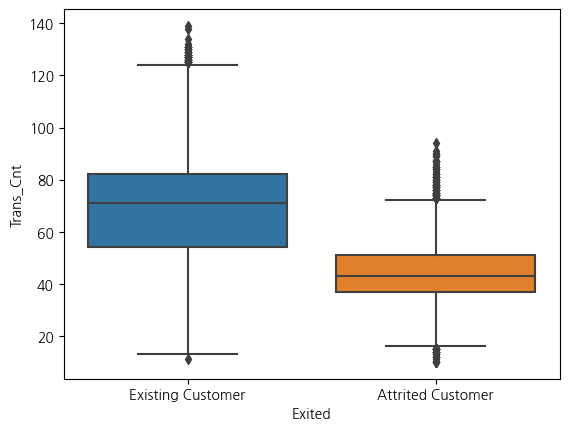

In [ ]:
sns.boxplot(data=df_eda4, x='Exited', y='Trans_Cnt')

거래횟수가 낮을수록 이탈 고객수가 많다 (30 ~ 60 사이)

거래횟수가 높을수록 유지 고객수가 많다 (60 ~ 100 사이)

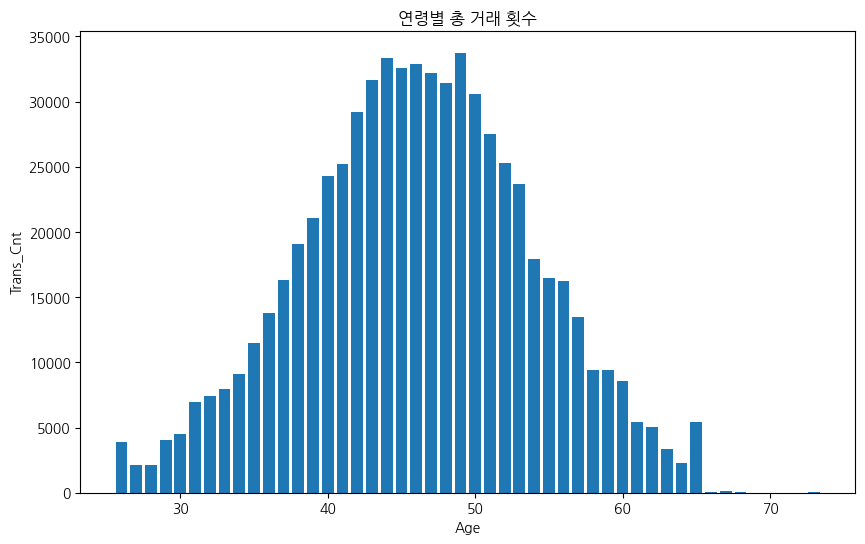

In [ ]:
# 연령별 총 거래 횟수

age_total_amount = df_eda4.groupby('Age')['Trans_Cnt'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(age_total_amount['Age'], age_total_amount['Trans_Cnt'])
plt.xlabel('Age')
plt.ylabel('Trans_Cnt')
plt.title('연령별 총 거래 횟수')
plt.show()

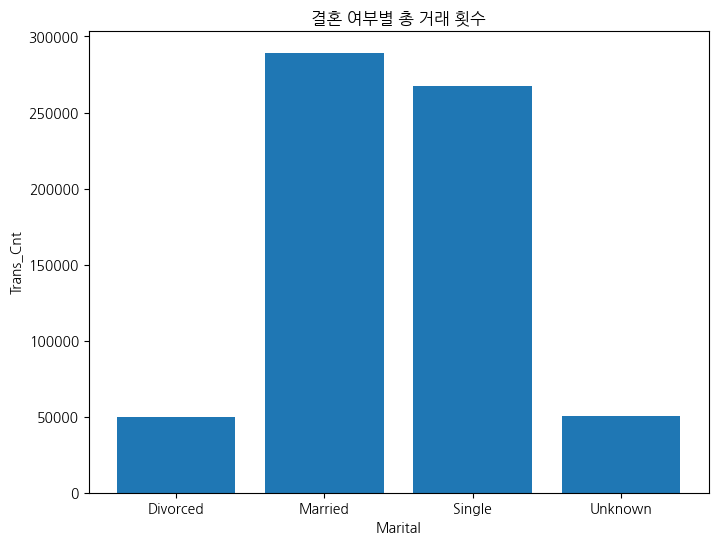

In [ ]:
# 결혼 여부별 총 거래 횟수

marital_total_amount = df_eda4.groupby('Marital')['Trans_Cnt'].sum().reset_index()

plt.figure(figsize=(8, 6))
plt.bar(marital_total_amount['Marital'], marital_total_amount['Trans_Cnt'])
plt.xlabel('Marital')
plt.ylabel('Trans_Cnt')
plt.title('결혼 여부별 총 거래 횟수')
plt.show()

Amt_Chng_Q4_Q1: 4분기에서 1분기로의 총 금액 변동 (int)

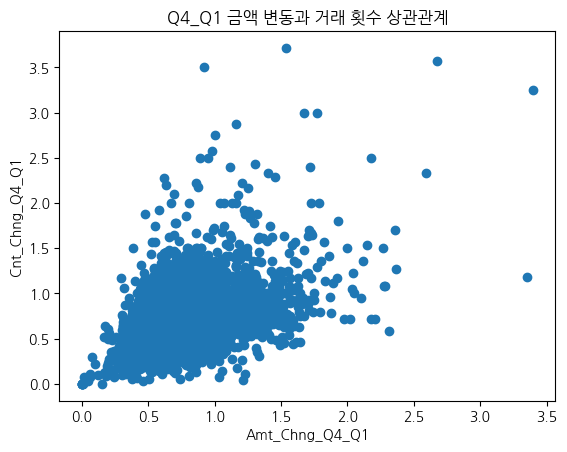

In [ ]:
# 산점도 그래프로 금액 변동과 거래 횟수 상관관계

plt.scatter(df_eda4['Amt_Chng_Q4_Q1'], df_eda4['Cnt_Chng_Q4_Q1'])
plt.xlabel('Amt_Chng_Q4_Q1')
plt.ylabel('Cnt_Chng_Q4_Q1')
plt.title('Q4_Q1 금액 변동과 거래 횟수 상관관계')
plt.show()

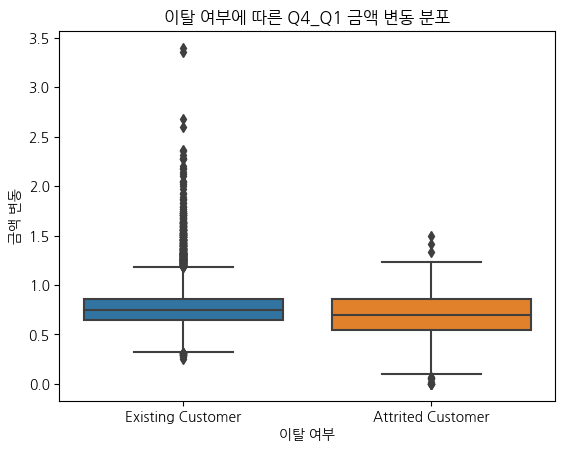

In [ ]:
# 이탈 여부에 따른 금액 변동 시각화

sns.boxplot(data=df_eda4, x='Exited', y='Amt_Chng_Q4_Q1')
plt.xlabel('이탈 여부')
plt.ylabel('금액 변동')
plt.title('이탈 여부에 따른 Q4_Q1 금액 변동 분포')
plt.show()

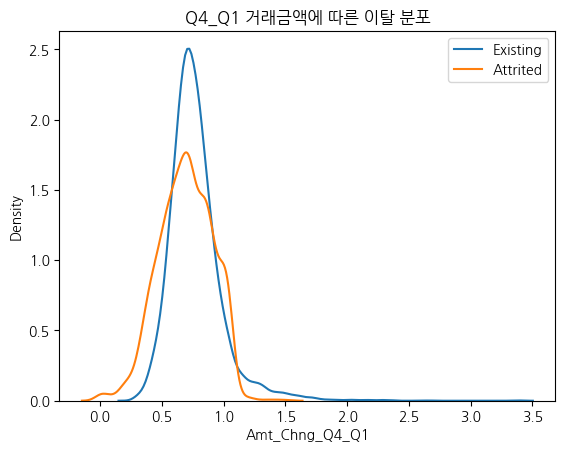

In [ ]:
# 거래금액에 따른 이탈 분포

exist_customers = df_eda4[df_eda4['Exited'] == 'Existing Customer']
attrited_customers = df_eda4[df_eda4['Exited'] == 'Attrited Customer']

sns.kdeplot(data=exist_customers, x='Amt_Chng_Q4_Q1', label='Existing')
sns.kdeplot(data=attrited_customers, x='Amt_Chng_Q4_Q1', label='Attrited')

plt.xlabel('Amt_Chng_Q4_Q1')
plt.ylabel('Density')
plt.title('Q4_Q1 거래금액에 따른 이탈 분포')
plt.legend()
plt.show()

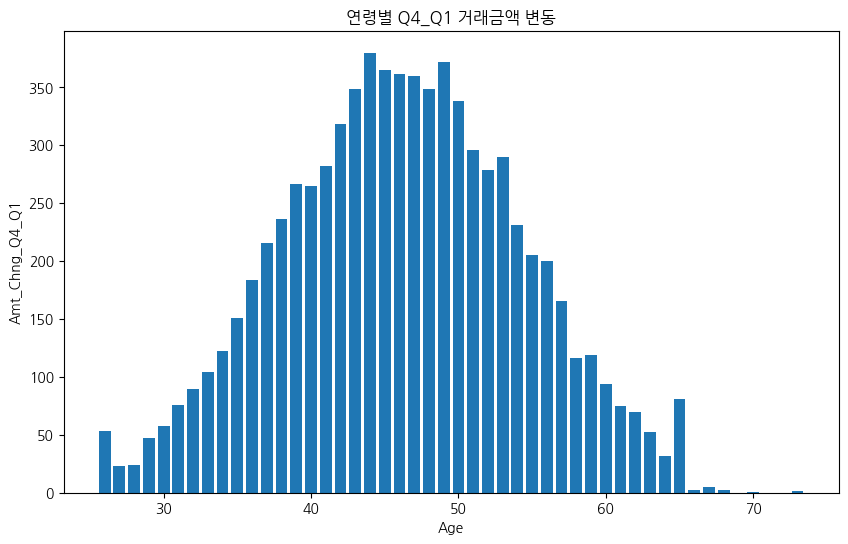

In [ ]:
# 연령별 Q4_Q1 거래금액 변동

age_total_amount = df_eda4.groupby('Age')['Amt_Chng_Q4_Q1'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(age_total_amount['Age'], age_total_amount['Amt_Chng_Q4_Q1'])
plt.xlabel('Age')
plt.ylabel('Amt_Chng_Q4_Q1')
plt.title('연령별 Q4_Q1 거래금액 변동')
plt.show()

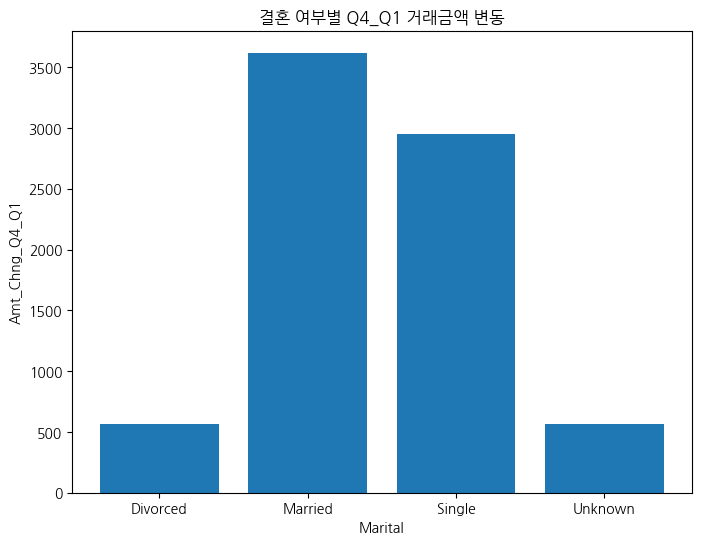

In [ ]:
# 결혼 여부별 Q4_Q1 거래금액 변동

marital_total_amount = df_eda4.groupby('Marital')['Amt_Chng_Q4_Q1'].sum().reset_index()

plt.figure(figsize=(8, 6))
plt.bar(marital_total_amount['Marital'], marital_total_amount['Amt_Chng_Q4_Q1'])
plt.xlabel('Marital')
plt.ylabel('Amt_Chng_Q4_Q1')
plt.title('결혼 여부별 Q4_Q1 거래금액 변동')
plt.show()

Cnt_Chng_Q4_Q1: 4분기에서 1분기로의 총 거래 횟수 변동 (int)

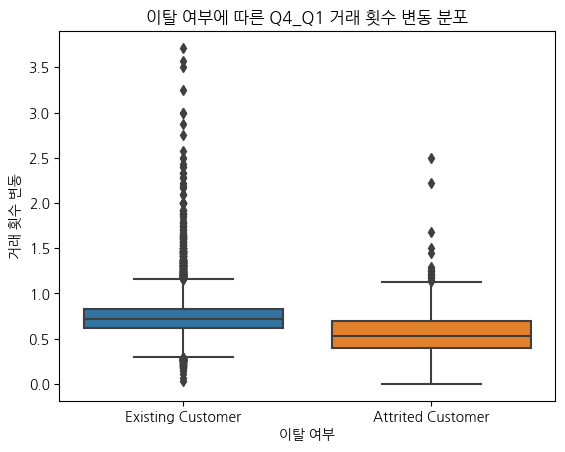

In [ ]:
# 이탈 여부에 따른 거래 횟수 변동 시각화

sns.boxplot(data=df_eda4, x='Exited', y='Cnt_Chng_Q4_Q1')
plt.xlabel('이탈 여부')
plt.ylabel('거래 횟수 변동')
plt.title('이탈 여부에 따른 Q4_Q1 거래 횟수 변동 분포')
plt.show()

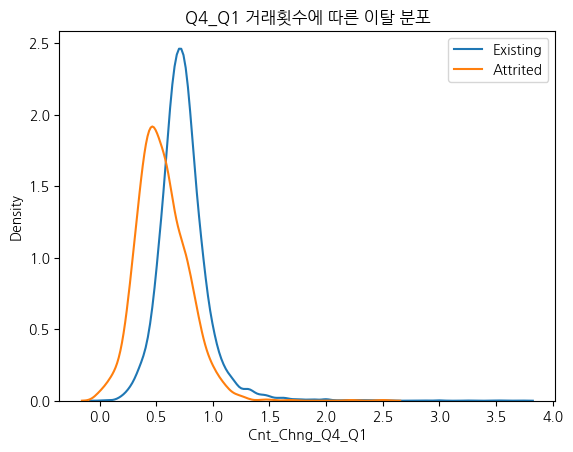

In [ ]:
# 거래횟수에 따른 이탈 분포

exist_customers = df_eda4[df_eda4['Exited'] == 'Existing Customer']
attrited_customers = df_eda4[df_eda4['Exited'] == 'Attrited Customer']

sns.kdeplot(data=exist_customers, x='Cnt_Chng_Q4_Q1', label='Existing')
sns.kdeplot(data=attrited_customers, x='Cnt_Chng_Q4_Q1', label='Attrited')

plt.xlabel('Cnt_Chng_Q4_Q1')
plt.ylabel('Density')
plt.title('Q4_Q1 거래횟수에 따른 이탈 분포')
plt.legend()
plt.show()

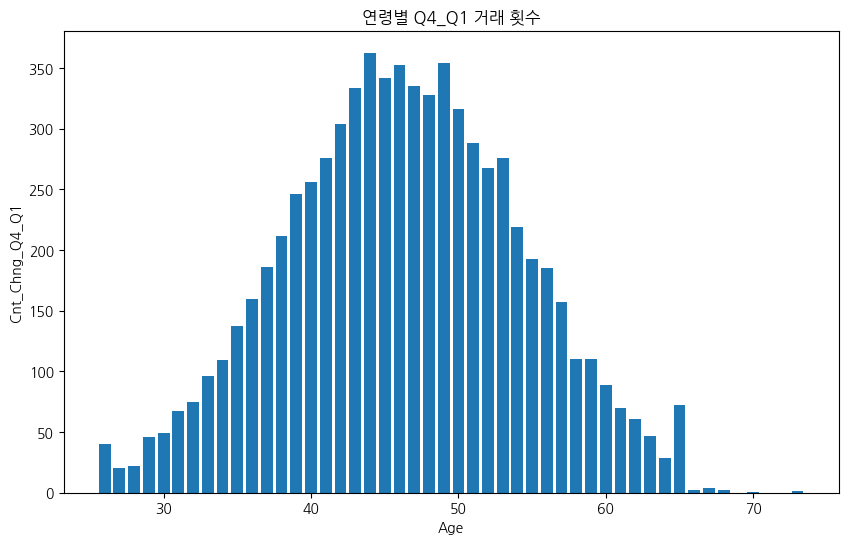

In [ ]:
# 연령별 Q4_Q1 거래 횟수

age_total_amount = df_eda4.groupby('Age')['Cnt_Chng_Q4_Q1'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(age_total_amount['Age'], age_total_amount['Cnt_Chng_Q4_Q1'])
plt.xlabel('Age')
plt.ylabel('Cnt_Chng_Q4_Q1')
plt.title('연령별 Q4_Q1 거래 횟수')
plt.show()

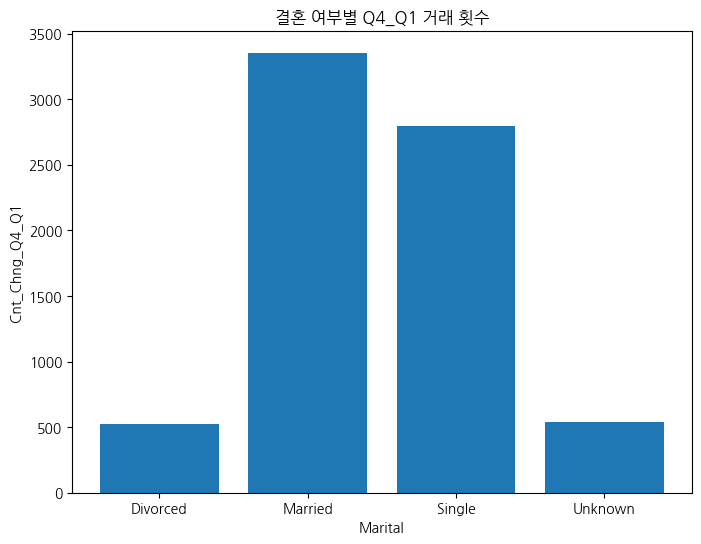

In [ ]:
# 결혼 여부별 총 거래 횟수

marital_total_amount = df_eda4.groupby('Marital')['Cnt_Chng_Q4_Q1'].sum().reset_index()

plt.figure(figsize=(8, 6))
plt.bar(marital_total_amount['Marital'], marital_total_amount['Cnt_Chng_Q4_Q1'])
plt.xlabel('Marital')
plt.ylabel('Cnt_Chng_Q4_Q1')
plt.title('결혼 여부별 Q4_Q1 거래 횟수')
plt.show()

boxplot

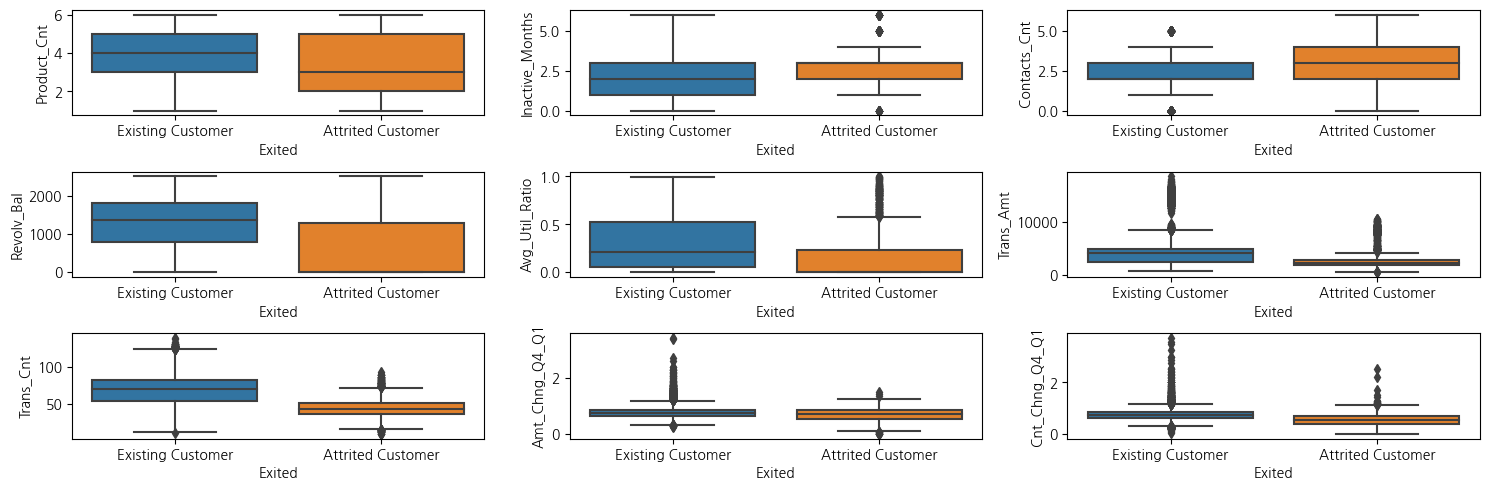

In [ ]:
# 9개 피쳐로 boxplot 그리기

plt.figure(figsize=(15, 5))
plt.subplots_adjust(wspace=0.4)

plt.subplot(3, 3, 1)
sns.boxplot(data=df_eda4, x='Exited', y='Product_Cnt')

plt.subplot(3, 3, 2)
sns.boxplot(data=df_eda4, x='Exited', y='Inactive_Months')

plt.subplot(3, 3, 3)
sns.boxplot(data=df_eda4, x='Exited', y='Contacts_Cnt')

plt.subplot(3, 3, 4)
sns.boxplot(data=df_eda4, x='Exited', y='Revolv_Bal')

plt.subplot(3, 3, 5)
sns.boxplot(data=df_eda4, x='Exited', y='Avg_Util_Ratio')

plt.subplot(3, 3, 6)
sns.boxplot(data=df_eda4, x='Exited', y='Trans_Amt')

plt.subplot(3, 3, 7)
sns.boxplot(data=df_eda4, x='Exited', y='Trans_Cnt')

plt.subplot(3, 3, 8)
sns.boxplot(data=df_eda4, x='Exited', y='Amt_Chng_Q4_Q1')

plt.subplot(3, 3, 9)
sns.boxplot(data=df_eda4, x='Exited', y='Cnt_Chng_Q4_Q1')

plt.tight_layout()
plt.show()

## 2. Feature engineering
- 라벨링

In [4]:
# 라벨링
exited = {'Existing Customer': 0, 'Attrited Customer':1}
gender = {'M':0, 'F':1}
education = {'Uneducated': 0, 'High School':1, 'College':2, 'Graduate':3, 'Post-Graduate': 4, 'Doctorate':5, 'Unknown':6}
marital = {'Single':0, 'Married': 1, 'Divorced':2, 'Unknown':3}
income = {'Less than $40K':0, '$40K - $60K':1, '$60K - $80K':2, '$80K - $120K':3, '$120K +':4, 'Unknown':5}
card = {'Blue':0, 'Silver':1 , 'Gold': 2, 'Platinum': 3}
df['Exited'] = df['Exited'].map(exited)
df['Gender'] = df['Gender'].map(gender)
df['Education'] = df['Education'].map(education)
df['Marital'] = df['Marital'].map(marital)
df['Income'] = df['Income'].map(income)
df['Card_Type'] = df['Card_Type'].map(card)
df.head()

,Exited,Age,Gender,Dependents,Education,Marital,Income,Card_Type,Tenure,Product_Cnt,Inactive_Months,Contacts_Cnt,Credit_Limit,Revolv_Bal,Avg_OTB,Avg_Util_Ratio,Trans_Amt,Trans_Cnt,Amt_Chng_Q4_Q1,Cnt_Chng_Q4_Q1
0,0,45,0,3,1,1,2,0,39,5,1,3,12691.0,777,11914.0,0.061,1144,42,1.335,1.625
1,0,49,1,5,3,0,0,0,44,6,1,2,8256.0,864,7392.0,0.105,1291,33,1.541,3.714
2,0,51,0,3,3,1,3,0,36,4,1,0,3418.0,0,3418.0,0.000,1887,20,2.594,2.333
3,0,40,1,4,1,3,0,0,34,3,4,1,3313.0,2517,796.0,0.760,1171,20,1.405,2.333
4,0,40,0,3,0,1,2,0,21,5,1,0,4716.0,0,4716.0,0.000,816,28,2.175,2.500


## 3. Feature selection
- RandomForestClassifier, XGBClassifier의 교차된 RFECV feature 개수 = 8 ~ 9개
- Exited 상관계수 상위 8 ~ 9개 컬럼
-  8 ~ 9개 컬럼으로 모델지표 비교하여 9개 컬럼의 F1 socre가 높아 선택
- 9개 컬럼 이탈 Boxplot 차이도 확인

- correlation

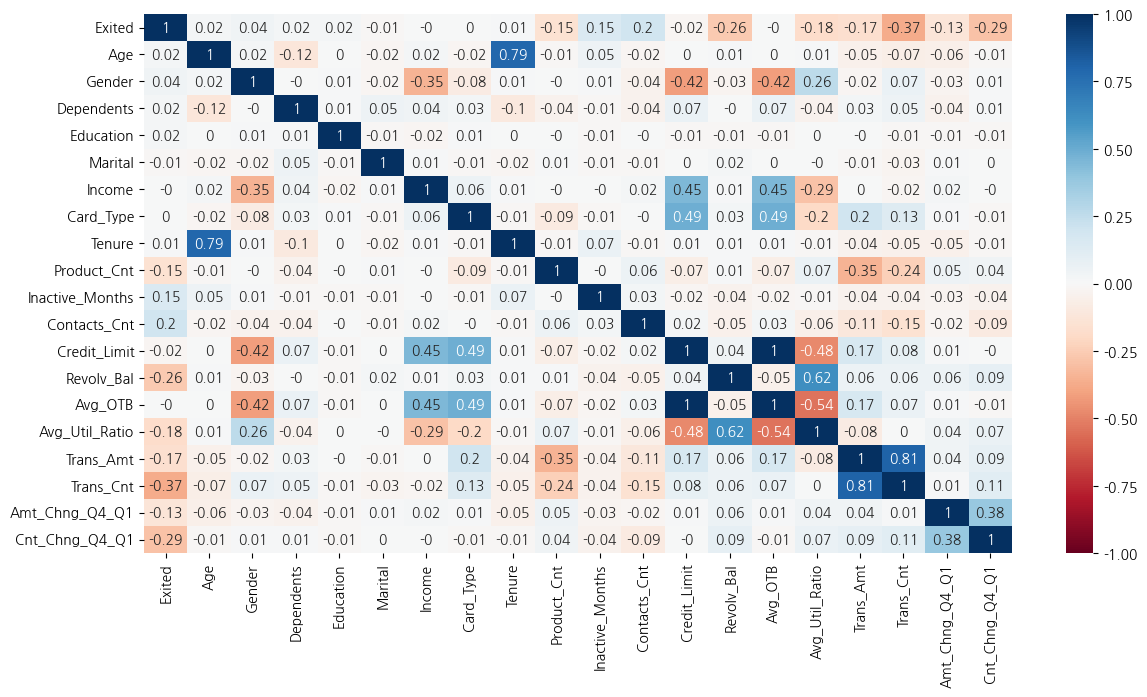

In [ ]:
correlation = df.corr(numeric_only=True).round(2)
plt.figure(figsize = (14,7))
sns.heatmap(correlation, annot = True, cmap = 'RdBu', vmin=-1, vmax=1)
plt.show()

- RFECV

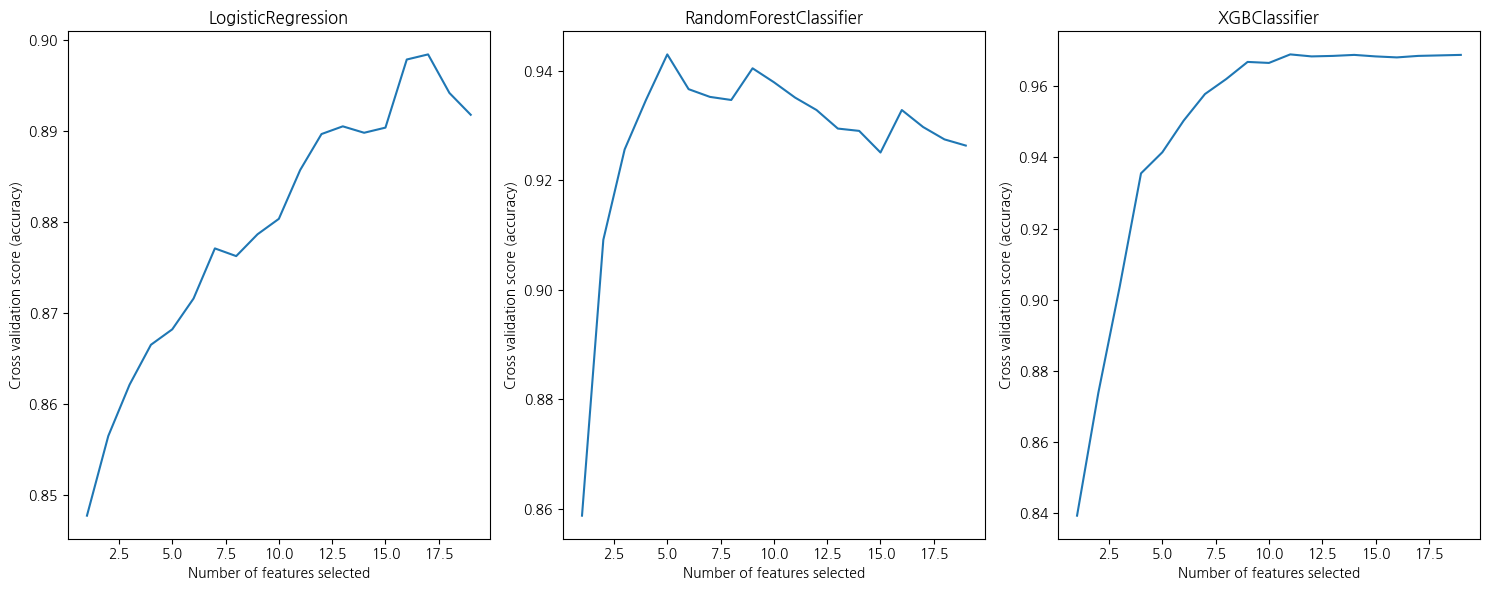

In [ ]:
X = df.drop(['Exited'], axis=1)
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13, stratify=y)

min_features_to_select = 1
step = 1

scaler = StandardScaler()
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

plt.figure(figsize=(15,6))

# LogisticRegression
plt.subplot(1, 3, 1)
clf = LogisticRegression(solver='liblinear', random_state=13)
selector = RFECV(estimator=clf, step=step, cv=skfold, min_features_to_select=min_features_to_select)
pipe = Pipeline([('feature_selection', selector), ('scaler', scaler), ('clf', clf)])
pipe.fit(X_train, y_train)
plt.plot(
    range(min_features_to_select, len(pipe.named_steps['feature_selection'].cv_results_['mean_test_score'])*step + min_features_to_select, step),
    pipe.named_steps['feature_selection'].cv_results_['mean_test_score'],
)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.title('LogisticRegression')

# RandomForestClassifier
plt.subplot(1, 3, 2)
clf = RandomForestClassifier(max_depth=6, random_state=13, n_jobs=-1)
selector = RFECV(estimator=clf, step=step, cv=skfold, min_features_to_select=min_features_to_select)
pipe = Pipeline([('feature_selection', selector), ('scaler', scaler), ('clf', clf)])
pipe.fit(X_train, y_train)
plt.plot(
    range(min_features_to_select, len(pipe.named_steps['feature_selection'].cv_results_['mean_test_score'])*step + min_features_to_select, step),
    pipe.named_steps['feature_selection'].cv_results_['mean_test_score'],
)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.title('RandomForestClassifier')

# XGBClassifier
plt.subplot(1, 3, 3)
clf = XGBClassifier(n_estimators=100, max_depth=6 ,random_state=13, use_label_encoder=False)
selector = RFECV(estimator=clf, step=step, cv=skfold, min_features_to_select=min_features_to_select)
pipe = Pipeline([('feature_selection', selector), ('scaler', scaler), ('clf', clf)])
pipe.fit(X_train, y_train)
plt.plot(
    range(min_features_to_select, len(pipe.named_steps['feature_selection'].cv_results_['mean_test_score'])*step + min_features_to_select, step),
    pipe.named_steps['feature_selection'].cv_results_['mean_test_score'],
)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.title('XGBClassifier')

plt.tight_layout()
plt.show()

- 모델 평가

In [ ]:
# 모델 평가 지표 데이터 프레임화
def pd_score(models, X, y, scale):

  scores = []

  for model in models:
    pipe = Pipeline([('scaler', scale), ('clf', model)])
    skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    model_name = str(model)
    acc = cross_val_score(pipe, X, y, scoring='accuracy', cv=skfold).mean()
    pre = cross_val_score(pipe, X, y, scoring='precision', cv=skfold).mean()
    re = cross_val_score(pipe, X, y, scoring='recall', cv=skfold).mean()
    f1 = cross_val_score(pipe, X, y, scoring='f1', cv=skfold).mean()

    scores.append([model_name, acc, pre, re, f1])

  df = pd.DataFrame(scores, columns=['name', 'accuracy', 'precision', 'recall', 'f1'])

  return df

In [ ]:
# 8개 컬럼 모델 평가 지표
X = df[['Product_Cnt', 'Inactive_Months', 'Revolv_Bal', 'Avg_Util_Ratio', 'Trans_Amt', 'Trans_Cnt', 'Amt_Chng_Q4_Q1','Cnt_Chng_Q4_Q1']]
y = df['Exited']
scaler = StandardScaler()

logistic = LogisticRegression(solver='liblinear', random_state=13)
randomforest = RandomForestClassifier(max_depth=6, random_state=13, n_jobs=-1)
knn = KNeighborsClassifier(n_neighbors=5)
xgb = XGBClassifier(n_estimators=100, max_depth=6 ,random_state=13, use_label_encoder=False)

models = [logistic, randomforest, knn, xgb]

result = pd_score(models, X, y, scaler)
result.head()

,name,accuracy,precision,recall,f1
0,"LogisticRegression(random_state=13, solver='li...",0.896218,0.739647,0.548838,0.629356
1,"RandomForestClassifier(max_depth=6, n_jobs=-1,...",0.934433,0.893580,0.672389,0.767165
2,KNeighborsClassifier(),0.930385,0.848893,0.690822,0.761249
3,"XGBClassifier(base_score=None, booster=None, c...",0.962279,0.902100,0.858630,0.879711


In [ ]:
# 9개 컬럼 모델 평가 지표
X = df[['Product_Cnt', 'Inactive_Months', 'Contacts_Cnt', 'Revolv_Bal', 'Avg_Util_Ratio', 'Trans_Amt', 'Trans_Cnt', 'Amt_Chng_Q4_Q1','Cnt_Chng_Q4_Q1']]
y = df['Exited']
scaler = StandardScaler()

logistic = LogisticRegression(solver='liblinear', random_state=13)
randomforest = RandomForestClassifier(max_depth=6, random_state=13, n_jobs=-1)
knn = KNeighborsClassifier(n_neighbors=5)
xgb = XGBClassifier(n_estimators=100, max_depth=6 ,random_state=13, use_label_encoder=False)

models = [logistic, randomforest, knn, xgb]

result = pd_score(models, X, y, scaler)
result.head()

,name,accuracy,precision,recall,f1
0,"LogisticRegression(random_state=13, solver='li...",0.898292,0.742063,0.564819,0.640557
1,"RandomForestClassifier(max_depth=6, n_jobs=-1,...",0.940752,0.889831,0.720934,0.796117
2,KNeighborsClassifier(),0.928311,0.840770,0.685297,0.754543
3,"XGBClassifier(base_score=None, booster=None, c...",0.964748,0.908250,0.868459,0.887775


## 4. Hyperparameter optimization

In [ ]:
X = df[['Product_Cnt', 'Inactive_Months', 'Contacts_Cnt', 'Revolv_Bal', 'Avg_Util_Ratio', 'Trans_Amt', 'Trans_Cnt', 'Amt_Chng_Q4_Q1','Cnt_Chng_Q4_Q1']]
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

GridSearchCV를 이용한 Logistic Regression 하이퍼파라미터

In [ ]:
# GridSearchCV를 이용한 Logistic Regression 하이퍼파라미터

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
estimators = [
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(solver='liblinear', random_state=13))
]
pipe = Pipeline(estimators)

# 탐색할 하이퍼파라미터들의 후보 값들
params = {
    'lr__C': [0.05, 0.1, 0.3, 0.5],  # C 값 후보
    'lr__penalty': ['l1', 'l2'],  # L1 정규화 또는 L2 정규화 후보
}

GridSearch = GridSearchCV(estimator=pipe, param_grid=params, cv=skf)
GridSearch.fit(X_train, y_train)

best = GridSearch.best_estimator_
pred = best.predict(X_test)

# best parameter
print(GridSearch.best_params_)

# 모델 평가 지표
print('Accuracy: ', accuracy_score(y_test, pred))
print('Precision: ', precision_score(y_test, pred))
print('Recall: ', recall_score(y_test, pred))
print('F1: ', f1_score(y_test, pred))
print('Roc-auc: ', roc_auc_score(y_test, pred))
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

{'lr__C': 0.05, 'lr__penalty': 'l2'}
Accuracy:  0.8993089832181639
Precision:  0.7510373443983402
Recall:  0.556923076923077
F1:  0.6395759717314488
Roc-auc:  0.7608248541581876
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1701
           1       0.75      0.56      0.64       325

    accuracy                           0.90      2026
   macro avg       0.84      0.76      0.79      2026
weighted avg       0.89      0.90      0.89      2026

[[1641   60]
 [ 144  181]]


In [ ]:
# 테스트 목록
score_df = pd.DataFrame(GridSearch.cv_results_)
score_df[['params', 'rank_test_score', 'mean_test_score', 'std_test_score']]

,params,rank_test_score,mean_test_score,std_test_score
0,"{'lr__C': 0.05, 'lr__penalty': 'l1'}",6,0.897914,0.005657
1,"{'lr__C': 0.05, 'lr__penalty': 'l2'}",1,0.898284,0.005007
2,"{'lr__C': 0.1, 'lr__penalty': 'l1'}",5,0.897914,0.004763
3,"{'lr__C': 0.1, 'lr__penalty': 'l2'}",1,0.898284,0.004773
4,"{'lr__C': 0.3, 'lr__penalty': 'l1'}",3,0.898037,0.004898
5,"{'lr__C': 0.3, 'lr__penalty': 'l2'}",8,0.897667,0.004992
6,"{'lr__C': 0.5, 'lr__penalty': 'l1'}",4,0.897914,0.004288
7,"{'lr__C': 0.5, 'lr__penalty': 'l2'}",7,0.897790,0.004396


GridsearchCV를 이용한 RandomForestClassifier 하이퍼파라미터




In [ ]:
model = RandomForestClassifier(random_state=13, n_jobs=-1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
estimators = [('scaler', StandardScaler()), ('clf', model)]

pipe = Pipeline(estimators)

# 탐색할 파라미터
params = [{'clf__n_estimators': [100, 200, 300, 400],
           'clf__max_depth': [3, 5, 7, 9],
           'clf__min_samples_split': [2, 5, 10],
           'clf__min_samples_leaf' : [1, 2, 4]
           }]

GridSearch = GridSearchCV(estimator=pipe, param_grid=params, cv=skf)
GridSearch.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=13, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=13))]),
             param_grid=[{'clf__max_depth': [3, 5, 7, 9],
                          'clf__min_samples_leaf': [1, 2, 4],
                          'clf__min_samples_split': [2, 5, 10],
                          'clf__n_estimators': [100, 200, 300, 400]}])

In [ ]:
# best parameter
print(GridSearch.best_params_)

# best 모델 평가 지표
best = GridSearch.best_estimator_
pred = best.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, pred))
print('Precision: ', precision_score(y_test, pred))
print('Recall: ', recall_score(y_test, pred))
print('F1: ', f1_score(y_test, pred))
print('Roc-auc: ', roc_auc_score(y_test, pred))
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

{'clf__max_depth': 9, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}
Accuracy:  0.9550839091806516
Precision:  0.8823529411764706
Recall:  0.8307692307692308
F1:  0.8557844690966719
Roc-auc:  0.9048026048026049
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1701
           1       0.88      0.83      0.86       325

    accuracy                           0.96      2026
   macro avg       0.93      0.90      0.91      2026
weighted avg       0.95      0.96      0.95      2026

[[1665   36]
 [  55  270]]


GridsearchCV를 이용한 KNN 하이퍼파라미터


In [ ]:
model = KNeighborsClassifier()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
estimators = [('scaler', StandardScaler()), ('knn', model)]

pipe = Pipeline(estimators)

# 탐색할 파라미터
grid_params = {
    'knn__n_neighbors' : [10,20,30,40,50,60,70,80,90,100],
    'knn__weights' : ["uniform", "distance"],
    'knn__metric' : ['euclidean', 'manhattan', 'minkowski']
}

GridSearch = GridSearchCV(estimator=pipe, param_grid=grid_params, cv=skf)
GridSearch.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=13, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['euclidean', 'manhattan', 'minkowski'],
                         'knn__n_neighbors': [10, 20, 30, 40, 50, 60, 70, 80,
                                              90, 100],
                         'knn__weights': ['uniform', 'distance']})

In [ ]:
# KNN 모델
print("Best Parameters : ", GridSearch.best_params_)
print("Best Score : ", GridSearch.best_score_)
print("Best Test Score : ", GridSearch.score(X_test, y_test))

Best Parameters :  {'knn__metric': 'manhattan', 'knn__n_neighbors': 10, 'knn__weights': 'distance'}
Best Score :  0.9359339989794441
Best Test Score :  0.932872655478776


In [ ]:
# 모델 평가 지표
knn_model = KNeighborsClassifier(metric = 'manhattan', n_neighbors = 10, weights = 'distance')
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
print('accuracy: ', accuracy_score(y_test, knn_pred))
print('precision: ', precision_score(y_test, knn_pred))
print('recall: ', recall_score(y_test, knn_pred))
print('f1: ', f1_score(y_test, knn_pred))
print(classification_report(y_test, knn_pred))
print(confusion_matrix(y_test, knn_pred))

accuracy:  0.9086870681145114
precision:  0.7287581699346405
recall:  0.6861538461538461
f1:  0.7068145800316956
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1701
           1       0.73      0.69      0.71       325

    accuracy                           0.91      2026
   macro avg       0.83      0.82      0.83      2026
weighted avg       0.91      0.91      0.91      2026

[[1618   83]
 [ 102  223]]


HyperOPt(베이지안)과 GridSearchCV와 를 이용한 XGBoost 하이퍼파라미터

In [ ]:
# hyperopt

# Objective 함수 정의
def objective(params):
    model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        seed=0,
        **params
    )
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    estimators = [('scaler', StandardScaler()), ('xgb', model)]

    pipe = Pipeline(estimators)

    score = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy').mean()
    return -score


# 탐색할 하이퍼파라미터 범위 설정
space = {
    'n_estimators': hp.choice('n_estimators', [100, 200, 300, 400]),
    'max_depth': hp.choice('max_depth', [3, 5, 7, 9]),
    'learning_rate': hp.choice('learning_rate', [0.01, 0.05, 0.1, 0.15, 0.2]),
    'min_child_weight': hp.choice('min_child_weight', [1, 3, 5, 7]),
    'subsample': hp.choice('subsample', [0.5, 0.7, 1]),
    'gamma': hp.choice('gamma', [0, 1, 2, 3])
}

# Trials 객체 생성
trials = Trials()

# HyperOpt를 사용하여 최적의 하이퍼파라미터 탐색
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

# 최적의 하이퍼파라미터 출력
best_hyperparams = space_eval(space, best)
best_accuracy = -trials.best_trial['result']['loss']
print("Best Parameters: ", best_hyperparams)
print("Best Accuracy: ", best_accuracy)

100%|██████████| 100/100 [18:48<00:00, 11.28s/trial, best loss: -0.9674120532212246]
Best Parameters:  {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.7}
Best Accuracy:  0.9674120532212246


In [ ]:
# GridSearchCV
model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=0)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
estimators = [('scaler', StandardScaler()), ('xgb', model)]

pipe = Pipeline(estimators)

# 탐색할 파라미터

params = [{'xgb__n_estimators': [100, 200, 300],
           'xgb__max_depth': [3, 5, 7, 9],
           'xgb__learning_rate': [0.01, 0.05, 0.1, 0.15, 2],
           'xgb__min_child_weight': [0, 1, 2],
           'xgb__subsample': [0.6, 0.7, 0.8],
           'xgb__gamma': [1, 2, 3]}]

GridSearch = GridSearchCV(estimator=pipe, param_grid=params, cv=skf, scoring='accuracy', verbose=1)
GridSearch.fit(X_train, y_train)

# 성능 결과표
score_df = pd.DataFrame(GridSearch.cv_results_)
score_df.sort_values(by='rank_test_score')
score_df.head()

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__gamma,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__min_child_weight,param_xgb__n_estimators,param_xgb__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.477629,0.042394,0.009273,0.001877,1,0.01,3,0,100,0.6,"{'xgb__gamma': 1, 'xgb__learning_rate': 0.01, ...",0.922270,0.929012,0.931481,0.927160,0.922840,0.926553,0.003545,1511
1,0.666445,0.006870,0.011629,0.001755,1,0.01,3,0,100,0.7,"{'xgb__gamma': 1, 'xgb__learning_rate': 0.01, ...",0.924121,0.927160,0.931481,0.925926,0.922222,0.926182,0.003132,1522
2,0.470336,0.094294,0.007977,0.001433,1,0.01,3,0,100,0.8,"{'xgb__gamma': 1, 'xgb__learning_rate': 0.01, ...",0.921653,0.927778,0.930864,0.925926,0.922222,0.925689,0.003450,1531
3,0.867850,0.015202,0.008794,0.000305,1,0.01,3,0,200,0.6,"{'xgb__gamma': 1, 'xgb__learning_rate': 0.01, ...",0.933991,0.939506,0.947531,0.939506,0.937654,0.939638,0.004431,1394
4,0.865340,0.053890,0.009558,0.001516,1,0.01,3,0,200,0.7,"{'xgb__gamma': 1, 'xgb__learning_rate': 0.01, ...",0.932141,0.936420,0.948148,0.938272,0.935185,0.938033,0.005437,1423


In [ ]:
# GridSearchCV(파라미터 후보 수 줄임)
model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=0)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
estimators = [('scaler', StandardScaler()), ('xgb', model)]

pipe = Pipeline(estimators)

# 탐색할 파라미터

params = [{'xgb__n_estimators': [300, 400],
           'xgb__max_depth': [3, 5, 7, 9],
           'xgb__learning_rate': [0.05, 0.1],
           'xgb__min_child_weight': [0, 1],
           'xgb__subsample': [0.7],
           'xgb__gamma': [0,1]}]

GridSearch = GridSearchCV(estimator=pipe, param_grid=params, cv=skf, scoring='accuracy', verbose=1)
GridSearch.fit(X_train, y_train)

# 성능 결과표
score_df = pd.DataFrame(GridSearch.cv_results_)
score_df.sort_values(by='rank_test_score')
score_df.head()


## 5. Oversampling
- X_train, y_train deep copy 해주세요!
- X_train1, y_train1: 김승민
- X_train2, y_train2: 한상현
- X_train3, y_train3: 한정연
- X_train4, y_train4: 박영주


Oversampling - Random Over-sampling

In [8]:
X = df[['Product_Cnt', 'Inactive_Months', 'Contacts_Cnt', 'Revolv_Bal', 'Avg_Util_Ratio', 'Trans_Amt', 'Trans_Cnt', 'Amt_Chng_Q4_Q1','Cnt_Chng_Q4_Q1']]
y = df['Exited']

X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

In [9]:
#오버 샘플링
# 파라미터를 'minority'라고 지정하면, 소수 집단에서 복원 추출을 수행하여 다수 집단 데이터수와 동일하게 맞춤
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X_train1, y_train1)

# 최적의 하이퍼파라미터로 XGBoost 모델 생성
XG_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    seed=0,
    gamma=0,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    n_estimators=300,
    subsample=0.7
)

estimators = [('scaler', StandardScaler()), ('clf', XG_model)]

pipe = Pipeline(estimators)
pipe.fit(X_over, y_over)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=0, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

In [10]:
# 테스트 데이터로 예측 수행
XG_pred = pipe.predict(X_test)
y_pred_probs = pipe.predict_proba(X_test)[:, 1]

# 정확도 평가
accuracy = accuracy_score(y_test, XG_pred)
print("Accuracy:", accuracy)

# 정밀도 평가
precision = precision_score(y_test, XG_pred)
print("Precision:", precision)

# 재현율 평가
recall = recall_score(y_test, XG_pred)
print("Recall:", recall)

# F1-score 평가
f1 = f1_score(y_test, XG_pred)
print("F1-score:", f1)

# AUC-ROC 평가
roc_auc = roc_auc_score(y_test, y_pred_probs)
print("AUC-ROC:", roc_auc)


Accuracy: 0.9585389930898321
Precision: 0.8265582655826558
Recall: 0.9384615384615385
F1-score: 0.8789625360230547
AUC-ROC: 0.9893999005110116


In [11]:
cm = confusion_matrix(y_test, XG_pred)

TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

specificity = TN / (TN + FP)
npv = TN / (TN + FN)

print('specificity : ', specificity)
print('npv : ', npv)

specificity :  0.9623750734861846
npv :  0.987929993964997


Oversampling - SMOTE

In [13]:
# 데이터 나누기
X = df[['Product_Cnt', 'Inactive_Months', 'Contacts_Cnt', 'Revolv_Bal', 'Avg_Util_Ratio', 'Trans_Amt', 'Trans_Cnt', 'Amt_Chng_Q4_Q1','Cnt_Chng_Q4_Q1']]
y = df['Exited']
X_train2, X_test, y_train2, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=13)

# SMOTE 오버샘플링
smote = SMOTE(random_state=13)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train2, y_train2)

# 최적의 하이퍼파라미터로 XGBoost 모델 생성
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    seed=0,
    gamma=0,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    n_estimators=300,
    subsample=0.7
)

estimators = [('scaler', StandardScaler()), ('clf', XG_model)]

pipe = Pipeline(estimators)
pipe.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=0, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

In [16]:
# 테스트 데이터로 예측 수행
y_pred = pipe.predict(X_test)
y_pred_probs = pipe.predict_proba(X_test)[:, 1]

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# 정밀도 평가
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# 재현율 평가
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# F1-score 평가
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

# AUC-ROC 평가
roc_auc = roc_auc_score(y_test, y_pred_probs)
print("AUC-ROC:", roc_auc)

Accuracy: 0.9565646594274433
Precision: 0.8264462809917356
Recall: 0.9230769230769231
F1-score: 0.872093023255814
AUC-ROC: 0.9875059919504364


              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1701
           1       0.83      0.92      0.87       325

    accuracy                           0.96      2026
   macro avg       0.91      0.94      0.92      2026
weighted avg       0.96      0.96      0.96      2026



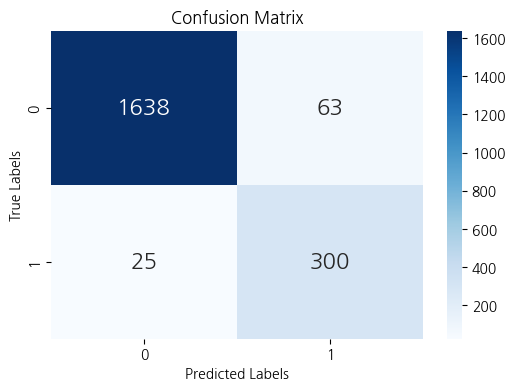

In [17]:
# Confusion Matrix 계산
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))

# Confusion Matrix 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 16})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

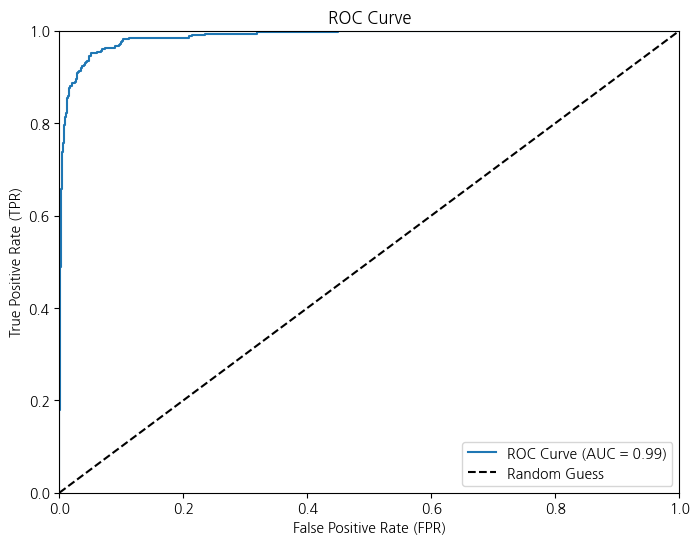

In [18]:
# ROC curve 계산
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# ROC curve 그리기
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_score(y_test, y_pred_probs)))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [19]:
# specificity / negative predictive value
cm = confusion_matrix(y_test, y_pred)

TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

specificity = TN / (TN + FP)
npv = TN / (TN + FN)

print('specificity : ', specificity)
print('npv : ', npv)

specificity :  0.9629629629629629
npv :  0.9849669272399278


Oversampling - Borderline-SMOTE

In [ ]:
# BorderlineSMOTE으로 오버샘플링
X = df[['Product_Cnt', 'Inactive_Months', 'Contacts_Cnt', 'Revolv_Bal', 'Avg_Util_Ratio', 'Trans_Amt', 'Trans_Cnt', 'Amt_Chng_Q4_Q1','Cnt_Chng_Q4_Q1']]
y = df['Exited']

X_train3, X_test, y_train3, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

# 오버샘플링
b_smote = BorderlineSMOTE(random_state=13)
X_resampled, y_resampled = b_smote.fit_resample(X_train3, y_train3)

model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    seed=0,
    gamma=0,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    n_estimators=300,
    subsample=0.7
)
estimators = [('scaler', StandardScaler()), ('clf', model)]

pipe = Pipeline(estimators)
pipe.fit(X_resampled, y_resampled)
pred = pipe.predict(X_test)

In [ ]:
# 평가지표
print('Accuracy : ', accuracy_score(y_test, pred))
print('Precision : ', precision_score(y_test, pred))
print('Recall : ', recall_score(y_test, pred))
print('F1 score : ', f1_score(y_test, pred))
print('Auc-Roc : ', roc_auc_score(y_test, pred))
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

Accuracy :  0.9521224086870681
Precision :  0.8
Recall :  0.9353846153846154
F1 score :  0.8624113475177304
Auc-Roc :  0.9453525075747298
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1701
           1       0.80      0.94      0.86       325

    accuracy                           0.95      2026
   macro avg       0.89      0.95      0.92      2026
weighted avg       0.96      0.95      0.95      2026

[[1625   76]
 [  21  304]]


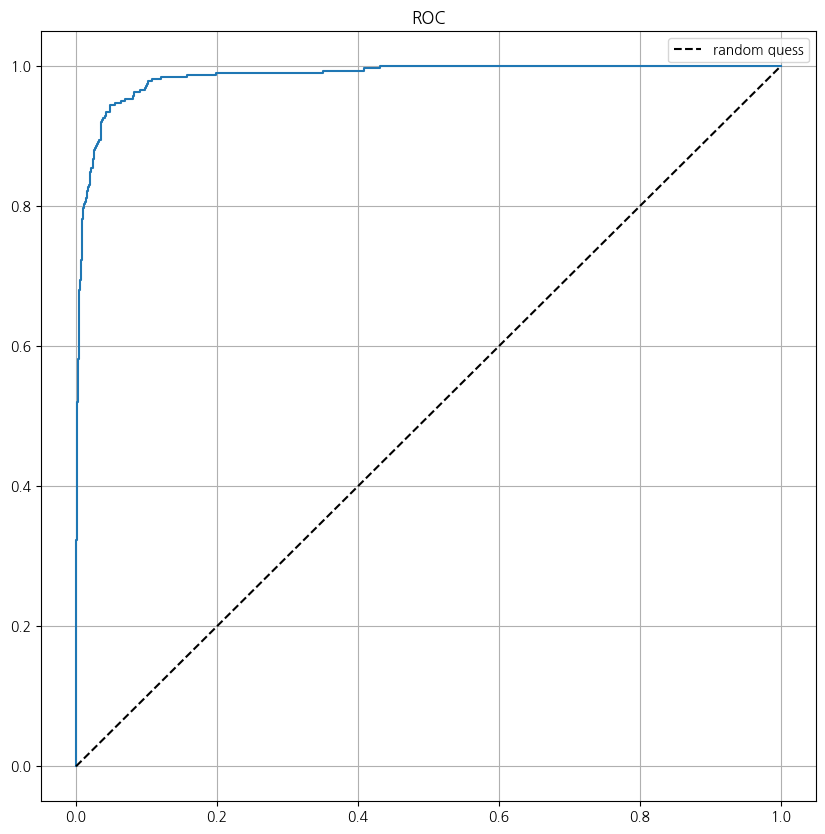

In [ ]:

# 테스트 데이터로 예측 수행
ypred = pipe.predict_proba(X_test)[:, 1]

# ROC curve 계산
fpr, tpr, thresholds = roc_curve(y_test, ypred)

# ROC curve 그리기
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--', label='random quess')
plt.title('ROC')
plt.legend()
plt.grid()
plt.show()

Oversampling - ADASYN

In [ ]:
# ADASYN으로 오버샘플링

X = df[['Product_Cnt', 'Inactive_Months', 'Contacts_Cnt', 'Revolv_Bal', 'Avg_Util_Ratio', 'Trans_Amt', 'Trans_Cnt', 'Amt_Chng_Q4_Q1','Cnt_Chng_Q4_Q1']]
y = df['Exited']

X_train4, X_test, y_train4, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

# 오버샘플링
adasyn = ADASYN(random_state=13)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train4,y_train4)


model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    seed=0,
    gamma=0,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    n_estimators=300,
    subsample=0.7
)

estimators = [('scaler', StandardScaler()), ('clf', model)]

pipe = Pipeline(estimators)
pipe.fit(X_resampled, y_resampled)
pred = pipe.predict(X_test)


In [ ]:
print('accuracy: ', accuracy_score(y_test, pred))
print('precision: ', precision_score(y_test, pred))
print('recall: ', recall_score(y_test, pred))
print('f1: ', f1_score(y_test, pred))
print('auc: ', roc_auc_score(y_test, pred))
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

accuracy:  0.9521224086870681
precision:  0.8
recall:  0.9353846153846154
f1:  0.8624113475177304
auc:  0.9453525075747298
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1701
           1       0.80      0.94      0.86       325

    accuracy                           0.95      2026
   macro avg       0.89      0.95      0.92      2026
weighted avg       0.96      0.95      0.95      2026

[[1625   76]
 [  21  304]]


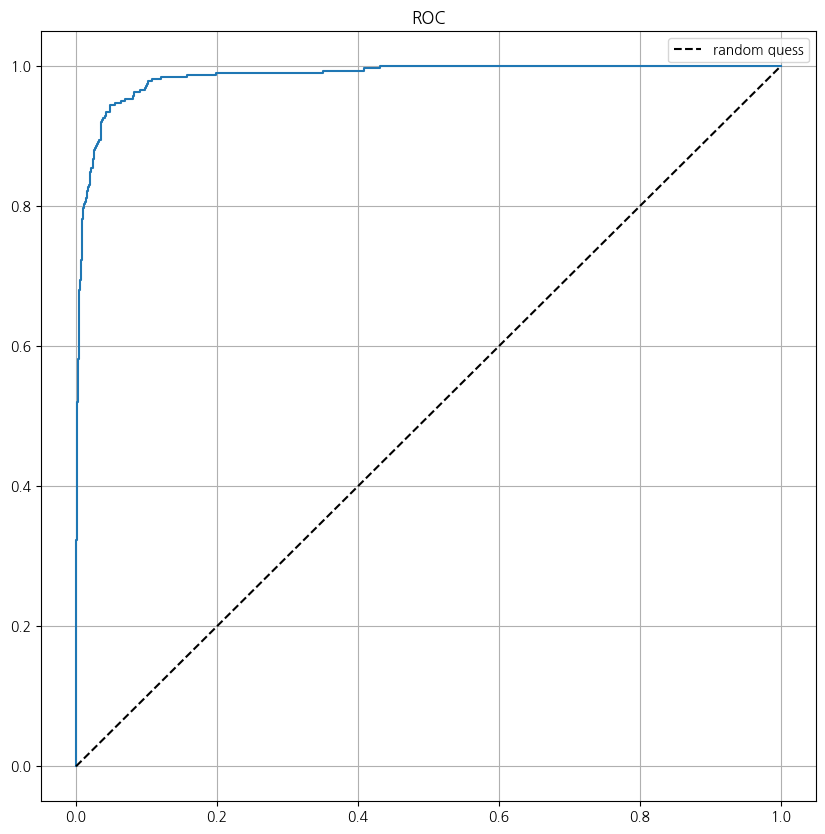

In [ ]:
plt.figure(figsize=(10, 10))

ypred = pipe.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, ypred)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--', label='random quess')
plt.title('ROC')
plt.legend()
plt.grid()
plt.show()

최종 모델 XGBoost + SMOTE로 선정

## 6. Feature importance

In [ ]:
X = df[['Product_Cnt', 'Inactive_Months', 'Contacts_Cnt', 'Revolv_Bal', 'Avg_Util_Ratio', 'Trans_Amt', 'Trans_Cnt', 'Amt_Chng_Q4_Q1','Cnt_Chng_Q4_Q1']]
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

# 오버샘플링
smote = SMOTE(random_state=13)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    seed=0,
    gamma=0,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    n_estimators=300,
    subsample=0.7
)
estimators = [('scaler', StandardScaler()), ('clf', model)]

pipe = Pipeline(estimators)
pipe.fit(X_resampled, y_resampled)
pred = pipe.predict(X_test)

Feature importance

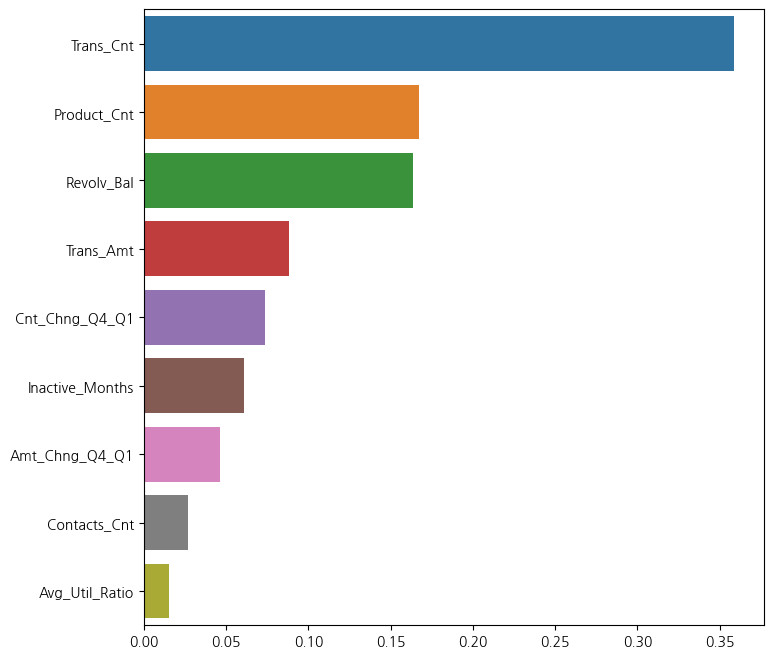

In [ ]:
best_cols_values = pipe['clf'].feature_importances_
best_cols = pd.Series(best_cols_values, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(8,8))
sns.barplot(x=best_cols, y=best_cols.index)
plt.show()

Shap value

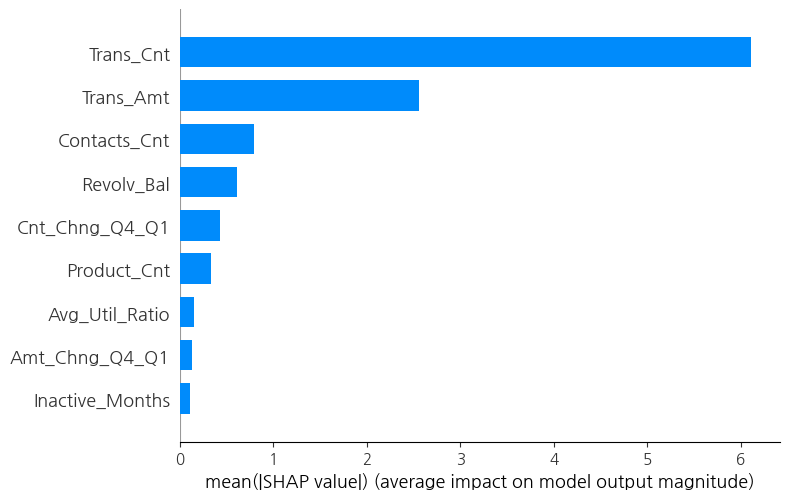

In [ ]:
explainer = shap.Explainer(pipe['clf'])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')